# A Partial Replication of "Fiscal and Monetary Policy with Heterogeneous Agents"

The aim of this self-contained script is to replicate Figure 2(a) and Figure 2(b) of Aucler, Rognlie, and Straub's 2025 paper titled "Fiscal and Monetary Policy with Heterogeneous Agents". It also tries to compute and plot an IRF displaying the evolution of inequalities.

## Introduction and setup

### Overview of the paper's contribution

This replication focuses on the fiscal policy experiments from the HANK (Heterogeneous-Agent New Keynesian) literature. The paper demonstrates that deficit-financed fiscal policy has much larger effects in heterogeneous-agent models compared to representative-agent models, due to:

1. High marginal propensities to consume (MPCs): Poor households spend a larger fraction of income
2. Incomplete markets: Households cannot fully smooth consumption, making them sensitive to current income
3. "Excess savings" dynamics: Households save part of tax cuts, then gradually spend down these savings over time

### What we are replicating

Figure 2(a) aims at comparing output responses to deficit-financed tax cuts across three models:
  - Heterogeneous Agent (HA): Full income/wealth heterogeneity with borrowing constraints
  - Two Agent (TA): Simple model with constrained and unconstrained households
  - Representative Agent (RA): Standard NK model (shows Ricardian equivalence)

Figure 2(b) illustrates how the HA model responds under alternative policy assumptions:
  - Baseline fiscal rule
  - Taxes concentrated on richest households
  - Active Taylor rule (monetary policy responds to inflation)
  - Angeletos-Lian-Wolf (2024) rule (self-financing deficits)

Plotting an inequality evolution IRFs would track how wealth inequality changes following the fiscal shock, illustrating the "trickling up" phenomenon where wealth becomes increasingly concentrated at the top.

### Methodological approach used by the authors (Sequence-Space Jacobians)

The code uses the sequence-space Jacobian toolkit developed by the authors. This method solves for first-order impulse responses using perfect-foresight (MIT) shocks, represents household behavior through intertemporal MPCs (iMPCs), makes decompositions of direct vs. indirect effects straightforward, and is supposedly computationally efficient compared to traditional state-space methods.

### Required packages and data

We need:
- `sequence_jacobian`: The authors' toolkit for solving HANK models
- Standard scientific Python: `numpy`, `scipy`, `matplotlib`
- Input files: Income process from Kaplan-Moll-Violante (2018)
- Calibrated parameters: Stored in `hh_params.json`

### Importing the required libraries

Core numerical libraries:
- `numpy`: Array operations and linear algebra
- `scipy`: Optimization (for calibration) and linear algebra (for Markov chains)
- `matplotlib`: Plotting

Sequence-space toolkit:
- `sequence_jacobian` (imported as `sj`): The authors' package for solving heterogeneous-agent models
  - Provides decorators like `@sj.het`, `@sj.simple`, `@sj.solved`
  - Handles Jacobian calculations automatically
  - Implements efficient forward simulation methods

Utilities:
- `json`: Load calibrated household parameters
- `os`: Create output directory for figures

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
from fontTools.ttx import process
from scipy import linalg, optimize
import sequence_jacobian as sj
import json

## PART 1: HOUSEHOLD BLOCKS

### Load income process from KMV

#### Household blocks: income process setup

##### Idiosyncratic income risk

A key ingredient of heterogeneous-agent macroeconomic models is that different households face different levels of income risk. In this project, each household’s labor income can move between several possible “income states,” such as low, medium, or high earnings. These movements follow a probabilistic rule, and the model must specify how likely it is for a household to move from one income state to another over time.

##### The Kaplan-Moll-Violante (2018) income process

The authors of the paper we replicate use a well-known income process from Kaplan, Moll, and Violante (2018). That process is originally defined in continuous time, which is convenient for theoretical modeling but not directly usable for numerical simulation. Our first step is therefore to transform the continuous-time object into a version that can be used in a computer simulation that runs period by period.

##### Code implementation

In [2]:
#The file ymarkov_combined.txt contains a matrix that describes how income evolves in continuous time. To make this object usable in discrete time (e.g., one period = one quarter), we apply the matrix exponential:
Pi_e = linalg.expm(np.loadtxt('inputs/kmv_process/ymarkov_combined.txt'))

#Taking the matrix exponential transforms the continuous-time transition rates into period-by-period transition probabilities. The resulting matrix Pi_e tells us, for each income state, the probability that a household will move to any other income state in the next period.
# After computing Pi_e, we make sure that each row sums to 1, because each row represents a full probability distribution over possible future income states:
Pi_e /= np.sum(Pi_e, axis=1)[:, np.newaxis]

#Once we know how households move between income states over time, we can compute the long-run distribution of households across these states. This is called the stationary distribution. It tells us, for example, what fraction of the population will have low, medium, or high income in the long run, assuming the transition probabilities remain constant.
#We compute it by calling:
pi_e = sj.utilities.discretize.stationary(Pi_e)
# This function finds the vector that satisfies the condition:πe=πeΠe
# meaning that if the population were distributed across income states according to pi_e, it would remain that way forever. This long-run distribution is useful because it allows us to construct averages (like mean income) that are consistent with the structure of the model.

#The model also needs to know the actual income associated with each state. The file ygrid_combined.txt contains this information, but it is stored in logarithms. We therefore transform these values back into levels:
e_grid_short = np.exp(np.loadtxt('inputs/kmv_process/ygrid_combined.txt'))

#Next, we normalize the income levels so that the average income equals 1. This normalization is without loss of generality: it makes interpretation easier (all other variables can then be measured relative to average income) and does not affect any of the model’s qualitative results.
#The normalization is done using the stationary distribution:
e_grid_short /= e_grid_short @ pi_e
#Here, e_grid_short @ pi_e computes the average income implied by the income levels and the long-run population distribution across income states. Dividing by this value rescales the entire income grid so that the mean becomes exactly one.

# Finally, we store the number of income states:
n_e = len(pi_e)
# This will be used later when constructing household behavior and distributions.

#### Discount factor heterogeneity

In models with household heterogeneity, it is important to explain why some households save a great deal while others save very little. In real data, we observe that a small fraction of households holds a very large share of total wealth, while many households have almost no savings. At the same time, households with little wealth tend to spend a larger fraction of any extra income they receive. A good model must therefore generate:
- Sufficiently high total wealth in the economy,
- High marginal propensities to consume (MPCs) for households with low wealth, and
- A realistic amount of wealth inequality.

Doing all three at once is surprisingly difficult. To address this, the paper adopts a simple but powerful idea: different households value the future differently. In other words, some households are naturally more patient than others.

The model assumes that households come in two “patience types,” which correspond to two different values of the discount factor β:
- Patient households have a discount factor close to 1. They value the future almost as much as the present, so they tend to save a lot and become wealthy.
- Impatient households have a noticeably lower discount factor. They care more about today than tomorrow, so they save much less and often hold very little wealth.

This simple distinction helps the model reproduce both high aggregate wealth (because patient households save heavily) and high MPCs (because impatient households have little buffer and spend most of their income).

The model assumes that in the long run, a certain fraction of households will be patient and the rest impatient. This long-run share is denoted by ω (omega). For example, if ω = 0.49, then about 49% of households will be patient in steady state.

To avoid treating patience type as a fixed lifelong characteristic, the model introduces a small probability that a household’s type may change. Specifically, each period, with probability q, a household receives a new “type draw” from the long-run distribution. This process can be interpreted as generational turnover: old households exit and new ones enter, inheriting characteristics randomly according to the stable distribution.

When q is small, here, q = 0.01, such changes are rare. On average, a household keeps its type for many years, which helps the model generate persistent differences in wealth.

This approach allows the model to simultaneously match realistic wealth inequality, high MPCs among low-wealth households, and a high overall level of wealth in the economy. Patient households accumulate substantial savings, while impatient households remain close to hand-to-mouth. The occasional type switching prevents the economy from splitting permanently into two non-interacting groups and helps stabilize the wealth distribution over time.

In [3]:
def make_betas(beta_hi, dbeta, omega, q):
    """Return beta grid and transition matrix"""
    # The model starts from the patient discount factor beta_hi. The impatient discount factor beta_lo is set to be lower by an amount dbeta. These two values are stored in a grid b_grid:
    beta_lo = beta_hi - dbeta
    b_grid = np.array([beta_lo, beta_hi])

    # The vector pi_b contains the steady-state probabilities of being impatient (first entry) or patient (second entry):
    pi_b = np.array([1 - omega, omega])

    # The transition matrix Pi_b tells us how households move between the two types from one period to the next:
    Pi_b = (1-q)*np.eye(2) + q*np.outer(np.ones(2), pi_b)
    return b_grid, Pi_b, pi_b

# The term (1-q)*np.eye(2) means that with probability 1−q, a household simply keeps its current type. The term q*np.outer(np.ones(2), pi_b) means that with probability q, a household receives a new type drawn from the long-run distribution pi_b. This structure ensures two important properties: Most households keep their type for long stretches (since q is small). Over time, the overall fraction of patient and impatient households converges exactly to pi_b.

#### Household optimization problem

In this model, each household decides how much to consume today and how much to save for the future. The decision is difficult because income is uncertain: some years a household receives high earnings, and other years low earnings. Saving allows households to smooth their consumption across good and bad times, but households face a simple constraint: they are not allowed to borrow, so their assets can never fall below zero.

To compute households’ optimal decisions, we solve their problem using a method called the endogenous grid method. Although the underlying economics involves dynamic programming, the key ideas can be explained without formal mathematics.

Here is what the model assumes:

- Households enjoy consumption, and their preferences are captured by a utility function. This notebook uses logarithmic utility, which means each extra unit of consumption makes them happier, but not by as much as the previous unit.
- Income varies from period to period because household productivity changes. Some households are lucky and receive high income; others experience low productivity and receive less.
- Households can save in a financial asset that earns a constant return r. They cannot borrow, so their asset holdings must remain non-negative.
- Different households may have different discount factors β, which affects how much they value future consumption relative to today.

This household block takes all the key ingredients of the household problem, income, assets, discounting, and uncertainty, and computes:
- the household’s optimal asset choice for next period,
- the consumption decision today, and
- the marginal value of assets, which captures how much households value saving.

These outputs feed into the aggregate model, allowing us to simulate how millions of heterogeneous households jointly respond to changes in fiscal or monetary policy.

In [4]:
# The function receives Va_p, which represents the marginal value of having one extra unit of assets tomorrow, based on the previous iteration of the algorithm. Intuitively, this tells us how helpful it would be to save more today: if the future looks risky or difficult, saving becomes more valuable.

@sj.het(exogenous='Pi', policy='a', backward='Va', backward_init=sj.hetblocks.hh_sim.hh_init)
def hh_raw(Va_p, a_grid, y, r, beta, eis):
    """Household block"""

    # Because different households have different discount factors  β, we multiply the continuation value by the household’s own discount factor:
    uc_nextgrid = beta[:, np.newaxis] * Va_p
    #This quantity represents the discounted value of consumption tomorrow, as seen from today.

    # With log utility, the marginal utility of consumption is simply 1/c. Thus, to recover the future consumption level that corresponds to a given marginal utility, we invert this relationship:
    c_nextgrid = uc_nextgrid ** (-eis)
    # Here, eis stands for “elasticity of intertemporal substitution,” and with log utility it equals 1. This line therefore converts marginal utility into consumption.

    # Each period, households receive income and the return on their savings. Their cash-on-hand, the total amount available before deciding how much to save, is:
    coh = (1 + r) * a_grid[np.newaxis, :] + y[:, np.newaxis]
    # This formula adds together: the return on assets from the previous period, and the income realizations for the current period. his is the budget households must allocate between consumption today and saving for tomorrow.

    # The most computationally expensive part of household problems is normally solving the first-order condition for optimal savings. The endogenous grid method (EGM) avoids this cost by working backwards: instead of guessing today’s savings, we start from future consumption and infer today’s optimal assets. This line performs that inference:
    a = sj.interpolate.interpolate_y(c_nextgrid + a_grid, coh, a_grid)
    # It determines the level of assets today (a) that would lead to the previously computed levels of consumption next period. The method is fast, stable, and widely used in modern computational economics.

    # Because households cannot borrow, we enforce the borrowing constraint:
    sj.misc.setmin(a, a_grid[0])
    # Here, a_grid[0] equals zero, meaning that assets today cannot be negative.

    # Once the model knows how much the household saves, the remainder must be consumed today. This comes directly from the household’s budget constraint:
    c = coh - a

    # Finally, the marginal value of assets today, the object needed for the next iteration of the dynamic programming loop, is computed using the envelope condition:
    Va = (1 + r) * c ** (-1 / eis)
    # This equation expresses the idea that an extra unit of savings today gives a household more consumption tomorrow, which is valuable when future consumption is scarce.

    return Va, a, c

#### Constructing the state space

To simulate many heterogeneous households, the model needs to keep track of the characteristics that make households different from one another. In this setting, each household is described by three key elements:

- Its patience type, captured by the discount factor β,
- Its productivity level, which determines its labor income, and
- Its asset holdings, which represent the household’s savings.

The function below constructs the grids and transition matrices that define this full state space.

This grid-building function assembles all the ingredients necessary to represent household heterogeneity in the model:
- A flexible grid of asset levels,
- Two types of households with different degrees of patience,
- Multiple productivity states capturing income risk,
- A complete transition matrix for joint state evolution, and
- A stationary distribution describing the long-run composition of the population.

Together, these objects form the backbone of the household side of the simulation.

In [5]:
def make_grids(min_a, max_a, n_a, beta_hi, dbeta, omega, q):
    """Create asset and beta grids"""

    # Every household can choose how much to save, and these savings determine its asset position next period. To model this choice, the program needs a range of possible asset levels that households can move through. We create this asset grid using:
    a_grid = sj.grids.asset_grid(min_a, max_a, n_a)
    # This function builds a list of asset values between a minimum (typically zero, because households cannot borrow) and a maximum value determined by the model. The grid is more finely spaced near zero, where small differences in assets can have big effects on household behavior. Further out, where decision rules are smoother, the grid spacing increases. This design makes the simulation both accurate and efficient.

    # Earlier, we defined a function make_betas(...) that constructs: the two discount factors (patient and impatient), the transition matrix describing how households switch between these types, and the long-run distribution across the two types.Calling that function:
    b_grid_short, Pi_b, pi_b = make_betas(beta_hi, dbeta, omega, q)
    # gives us everything we need to represent differences in patience.

    # Each household has both a productivity level and a patience type. The model must therefore consider all possible combinations. For example, a household might be: impatient and low productivity, impatient and medium productivity, impatient and high productivity,patient and low productivity,… and so on.
    # To create these combinations, we use the Kronecker product, which mechanically forms every pairing between the β types and the productivity levels:
    e_grid = np.kron(np.ones_like(b_grid_short), e_grid_short)
    beta = np.kron(b_grid_short, np.ones_like(e_grid_short))
    # The resulting vectors have one entry for each possible (β, productivity) combination. If there are 2 patience types and 7 productivity states, we obtain 14 distinct household types in the model. Each one corresponds to a specific combination of income potential and foresight.

    # Household characteristics evolve over time. Productivity changes according to the process we imported earlier, and the patience type changes occasionally according to the “generational turnover” mechanism.
    # Because the model assumes these two processes are independent, the transition rules for the full combined (β, productivity) state are obtained by taking the Kronecker product of the two transition matrices:
    Pi = np.kron(Pi_b, Pi_e)
    # This produces a 14×14 transition matrix that specifies the probability of moving from any current state to any next state.

    # Finally, the model needs to know the proportion of households in each combined state in the long run. Since the β and productivity processes are independent, we obtain the joint distribution simply by taking the Kronecker product of their individual stationary distributions:
    pi_pdf = np.kron(pi_b, pi_e)
   # This gives us a 14-element vector describing the steady-state fraction of households in each (β, productivity) state.

    return e_grid, Pi, a_grid, beta, pi_pdf

#### Income with cyclical risk

In addition to long-run income differences, households in the model are also affected by the business cycle. When the economy expands and employment rises, most households earn more. When the economy contracts, earnings fall. However, not all households experience these changes in the same way. Some may be hit harder during a recession, while others may see their incomes hardly change at all.

The purpose of the income() function is to determine each household’s income in a way that allows the model to explore different assumptions about how unevenly economic fluctuations are shared across the population.

At a basic level, each household’s labor income is the product of two components:
- Its individual productivity, represented in the code by e_grid, and
- The aggregate wage bill in the economy, represented by wN_aftertax.

If the economy is doing well and total employment N is high, the aggregate wage bill rises, and all households earn more. If N falls, the aggregate wage bill shrinks, and household incomes decline.

The simplest version of the model would assume that every household’s income rises or falls in exact proportion to the aggregate economy. But real-world data show that this is not the case: recessions typically hit low-income workers harder, and booms tend to benefit higher-productivity workers more. The model allows us to capture this type of unequal exposure.

The key idea is embodied in the parameter ζ (zeta), which adjusts how sensitive each household’s income is to changes in aggregate employment:
- When ζ = 0, all households experience the business cycle in the same proportion.
This is the “neutral” case.
- When ζ < 0, households with low productivity are hit harder during recessions and benefit less during expansions.
This represents countercyclical inequality, which is common in real data.
- When ζ > 0, low-productivity households are relatively insulated during recessions and benefit more during booms.
This corresponds to procyclical equality, which is less typical but useful to study.

The income() function provides a flexible way to model how households’ incomes respond to the business cycle. It allows the researcher to test different assumptions about how recessions and expansions affect low-income and high-income households, and it incorporates optional tax changes on the richest group for specific policy experiments. This flexibility is important because differences in income risk and exposure to shocks can significantly influence saving behavior, spending responses, and ultimately the macroeconomic effects the model aims to study.

In [6]:
def income(wN_aftertax, N, e_grid, Tr_lumpsum, Tax_richest, zeta, pi_pdf):
    """Calculate income with cyclicality parameter"""

    # The following line constructs a scaling factor gamma_N that applies this ζ-dependent adjustment to each productivity type:
    gamma_N = e_grid ** (zeta * np.log(N)) / np.vdot(e_grid ** (1 + zeta * np.log(N)), pi_pdf)
    # This expression works as follows: The numerator adjusts each household’s productivity according to ζ and the state of the economy (captured by log(N)). The denominator rescales the entire vector so that total labor income across all households remains consistent with aggregate employment. This ensures that the model stays internally coherent: if the wage bill is fixed at the aggregate level, individual incomes must add up to that same total.

    # Household income is then computed as:
    y = wN_aftertax * e_grid * gamma_N + Tr_lumpsum
    # This formula combines: the adjusted labor income term, and any lump-sum transfers financed by the government. The result is a full vector of incomes, one for each household state.

    # In some experiments, corresponding to Figure 2(b) of the paper, we want to study what happens when additional taxes are levied specifically on the households in the highest income group. To implement this, the function reshapes the income vector so that it can isolate the highest productivity group, subtracts the tax burden from that group alone, and then returns the flattened vector:
    y = y.reshape(-1, n_e)
    y[:, -1] -= Tax_richest / pi_e[-1].sum()
    y = y.ravel()
    # This procedure ensures that: Only the richest productivity state (usually the seventh state) pays the additional tax, The tax is spread proportionally across all households in that group, and The overall income vector maintains the correct structure for subsequent computation.

    return y

### Consolidated HA household block

Up to this point, we have constructed several components separately:
- The core household decision rule (hh_raw), which determines how households consume and save,
- The functions that build grids for assets, productivity, and discount-factor types (make_grids), and
- The function that computes each household’s income in every period (income).

Each of these pieces performs one part of the overall task. The next step is to assemble them into a single object that the general equilibrium model can use.

This is done using the following two lines.

These two lines of code take the individual components of household behavior, decision rules, income, and grids, and merge them into a complete heterogeneous-agent household block. This is the version used in the macroeconomic model, where millions of virtual households interact through wages, taxes, saving behavior, and policy shocks.

In [7]:
# The method .add_hetinputs() takes the basic household optimization problem defined in hh_raw and attaches the additional ingredients that describe household heterogeneity.
hh_ha = hh_raw.add_hetinputs([make_grids, income])
# This does two things: It links the grid construction to the household problem. The model now knows how many household types there are, what assets they can choose, and how their states evolve over time.
# It links the income process to the household problem. The household block now incorporates the computation of income ,  including income risk, business-cycle adjustments, and optional taxes on richer households.
# By combining these functions, we create a fully specified heterogeneous-agent household block. This block includes: the household’s decision rules (how much to save and consume), the full state space (assets × productivity × patience type), the transition probabilities between states, and the income each household receives in every state. The general equilibrium solver will rely on this combined object to compute aggregate behavior, distributions, and impulse responses.

# This line assigns a readable name to this household block:
hh_ha.name = 'hh_ha'

### Two-agent block

The full heterogeneous-agent household block used earlier captures many realistic features of household behavior: saving, borrowing constraints, income risk, and differences in patience. While this level of detail is important, it can also be computationally demanding.

To build intuition and to compare with the simpler models discussed in the paper, the notebook also includes a Two-Agent (TA) or “TANK” model. This model, originally developed by Bilbiie (2008), divides households into just two groups:
- “Hand-to-mouth” households, who consume all their current income and hold no financial assets.
- Unconstrained households, who behave like a standard representative agent and smooth consumption over time.

This simplified structure preserves some heterogeneity, because not all households behave alike, but is much easier to compute than the full HANK model.

In this setting, a fraction  λ of households is hand-to-mouth. These households have no savings and consume their entire wage income each period. The remaining fraction 1−λ consists of unconstrained households who choose consumption and asset holdings in order to keep their consumption path smooth over time.

The model then aggregates consumption across these two groups based on their population shares. This gives a simple but powerful way to capture heterogeneous consumption responses to policy changes.

The model uses a special decorator, @sj.solved, which tells the sequence-space solver that:
- Two variables must be determined endogenously: C_RA: consumption of the unconstrained households, A: their asset holdings.
- Two equations must hold exactly: The Euler equation, which describes optimal consumption smoothing, The budget constraint, which ensures overall resources are used consistently.

The solver automatically finds the time paths of C_RA and A that satisfy these two conditions for every period in the simulation.

This approach is extremely fast, because it avoids solving a full dynamic programming problem like in the HANK block. It makes the TA model ideal for comparisons and sanity checks.

In [8]:
@sj.solved(unknowns={'C_RA': 1, 'A': 1}, targets=["euler", "budget_constraint"])
def hh_ta(C_RA, A, wN_aftertax, eis, beta, r, lam):

    # The first condition inside the function represents the unconstrained households’ decision to smooth consumption over time. It says that the value of consuming a little less today should equal the value of consuming a little more tomorrow. Unconstrained households spread their consumption evenly across time, adjusting it in response to interest rates and discounting:
    euler = (beta * (1 + r(+1))) ** (-eis) * C_RA(+1) - C_RA

    # Hand-to-mouth households in this model have no savings and simply consume their entire current income:
    C_H2M = wN_aftertax
    # This makes them very sensitive to changes in income. If taxes change or wages move, their consumption adjusts immediately. This is why the TA model can produce higher short-run spending responses than a pure representative-agent model.

    # Total consumption in the economy is a weighted average of the two groups:
    C = (1 - lam) * C_RA + lam * C_H2M
    # If λ is large, the economy behaves more like a hand-to-mouth economy with strong immediate consumption responses to income changes. If λ is small, the economy behaves more like a representative-agent model.

    # Finally, the budget constraint ensures that unconstrained households’ saving and consumption choices respect their available resources:
    budget_constraint = (1 + r) * A(-1) + wN_aftertax - C - A
    # Their spending plus their savings must equal their income plus the return on last period’s assets.

    return euler, budget_constraint, C_H2M, C

# The parameter λ determines how many households are hand-to-mouth. It is set so that the TA model matches the same impact marginal propensity to consume (MPC) of 0.20 used in the HANK calibration.This gives a value close to: lam = 0.195, meaning roughly 20% of households in this simplified model consume all their income each period.

### Representative agent block

In addition to the detailed heterogeneous-agent model and the intermediate two-agent model, this notebook also includes the simplest possible household block: the Representative-Agent (RA) model. This framework assumes that all households are identical, same patience, same income response, same savings behavior, and that they all behave as perfectly optimizing consumers.

Although this version of the model is far less realistic than the HANK or TA models, it serves an important purpose. It acts as a theoretical benchmark that helps us understand how much of the model’s behavior comes from household heterogeneity versus standard macroeconomic mechanisms.

Unlike the heterogeneous-agent model, where households differ in income, patience, and wealth, or the TA model, where some households are hand-to-mouth, the RA model assumes that everyone behaves exactly like the same infinitely-lived consumer.

This implies that:
- All households have enough assets to smooth consumption.
- No one is constrained or forced to consume their full income.
- Everyone satisfies the same optimality condition (the Euler equation).
- Distributional issues disappear completely.

Because of this, the RA model generates the classic macroeconomic result known as Ricardian equivalence: deficit-financed tax cuts have essentially no effect on consumption or output, because households understand that future taxes will offset today’s tax cuts.

The RA model uses the same @sj.solved decorator as the TA model. This decorator tells the solver that two variables must be determined endogenously:
- C: the representative consumer’s consumption,
- A: the representative consumer’s asset holdings.

And that these variables must satisfy two conditions: The Euler equation, capturing intertemporal optimization, and the budget constraint, capturing the flow of income and savings.

The solver automatically computes the entire time path of consumption and assets that satisfies these conditions for any given economic environment or shock.

In the paper’s context, the RA model is plotted alongside the TA and HANK models in Figure 2(a) to emphasize the dramatic difference: unlike the HA model, the RA model predicts almost no response of output to deficit-financed tax cuts.

In [9]:
@sj.solved(unknowns={'C': 1, 'A': 1}, targets=["euler", "budget_constraint"])
def hh_ra(C, A, wN_aftertax, eis, beta, r):

    # This first equation expresses the representative agent’s desire to smooth consumption over time. It states that the marginal value of consuming slightly more today must match the discounted, interest-adjusted value of consuming slightly more tomorrow. In simpler terms, it ensures that consumption changes smoothly from one period to the next, adjusting in response to interest rates and the household’s patience level:
    euler = (beta * (1 + r(+1)))**(-eis) * C(+1) - C

    # The second equation is a straightforward accounting relationship: Households start the period with their previous assets, which earn return r. They add their current after-tax wage income. They allocate some of these resources to consumption (C) and the rest to savings (A).The RA model simply enforces that income plus asset returns must equal consumption plus savings:
    budget_constraint = (1 + r) * A(-1) + wN_aftertax - C - A

    return euler, budget_constraint

## PART 2: GENERAL EQUILIBRIUM BLOCKS

### General equilibrium model structure

We now build the "supply side" and market-clearing conditions that complete the HANK model.

#### Production block

To complete the economic environment, the model needs a description of how firms produce output and how income is divided between workers and firm owners. The production side of the model used here is intentionally simple: firms use labor as their only input, and output equals the total amount of labor hired.

Although this setup may look minimal, it is sufficient for simulating the aggregate behavior of the economy in response to fiscal and monetary shocks.

The production block performs three key tasks:
- It determines labor demand as equal to output.
- It splits total income between workers and shareholders using a fixed markup.
- It produces wage income and dividends in a form the rest of the model can use.

In [10]:
@sj.simple
# This function signals to the sequence-space modeling framework that:
# This block does not involve dynamic decision-making or optimization,
# It is simply a set of algebraic relationships between inputs and outputs, and
# Its derivatives (needed for impulse response calculations) can be computed automatically.

def production(Y, mu):
    """Split aggregate income into pre-tax wage and dividends"""

    # The model assumes that output  Y is produced using only one input: labor. There is no physical capital in this version of the model, and production is as straightforward as:
    N = Y
    # This means that labor demand by firms is equal to output. If output rises, firms hire more labor; if output falls, labor demand falls.

    # Firms charge a price that is a fixed percentage above their labor cost. This percentage is called the markup, denoted  μ. A markup greater than one means firms charge more for the product than they pay in wages. The real wage bill, total wages paid to workers, is calculated as:
    wN = Y / mu
    # Intuitively: If the markup is large, firms keep a large share of income as profits. If the markup is close to one, wages make up most of total income. This simple rule captures how income is divided between workers and firm owners without modeling price-setting behavior in detail.

    # Once wages are paid, any remaining part of output is counted as dividends, which are paid out to shareholders:
    div = Y - wN
    # This mirrors how profits work in real-world firms: total revenues minus labor costs equals residual profits.

    return N, wN, div

#### Government debt structure

In addition to describing households and firms, the model must also specify what kind of government debt exists in the economy. This matters because fiscal policy (such as tax cuts or government spending) and monetary policy (such as interest-rate changes) operate partly through the value and returns of government bonds.

The block below defines real, short-term government bonds, that is, bonds that are guaranteed in real (inflation-adjusted) terms, mature after one period (one quarter), and are rolled over continuously.

Government debt plays a key role in the model: It links fiscal policy (taxes and spending) with households’ saving decisions. It gives households a safe asset in which to store savings. It determines how interest-rate changes affect the economy.

Short-term real bonds are the simplest type of debt the government can issue. Because their return is guaranteed in real terms, households face no risk from inflation when holding them. Because they mature quickly, there is no risk from changes in interest rates across different maturities.

This makes them ideal for understanding the basic mechanics of policy transmission.

When the central bank cuts the real interest rate, the new promised return rante falls immediately. Therefore, the price of new bonds rises immediately (because q=1/(1+r)). However, the return on the bonds issued last period, the bonds households are currently holding, does not change right away. They still pay the old return rante (−1).

This means monetary policy affects: The value of new saving decisions (through higher bond prices), but not the money households are receiving today from previously purchased bonds.

In [11]:
@sj.simple

# This function takes as input r_ante. This represents the ex-ante real interest rate, meaning the interest rate promised on a bond before households decide how much to save. Monetary policy determines this return.
def real_ST_bonds(r_ante):
    """Bond returns if bonds are short term and real"""

    # However, the return that households actually receive at maturity is:
    r_post_bonds = r_ante(-1)
    # This means “take last period’s promised interest rate.” Because the bonds are real (inflation-protected), the promised return from the previous period is exactly what households receive now. There is: no inflation risk, because the bonds are real, and no maturity risk, because the bonds mature every period. This distinction between promised future returns and realized past returns is important because it determines the timing of how monetary policy affects households’ income.

    # The next line computes the bond price:
    qbond = 1/(1 + r_ante)
    # This price is simply the present value of one unit of consumption promised next period. If interest rates are high, the price is low; if interest rates are low, the price is high. This price is used by the government in its budget constraint, especially when fiscal policy aims to stabilize debt service or issue new debt.

    return r_post_bonds, qbond

#### Fiscal policy: taxes and government budget

The government plays an essential role in the model. It collects taxes, purchases goods and services, and issues debt. The fiscal block describes how these elements fit together in a consistent way.

At the heart of the fiscal system is the government’s budget constraint, which states that:
Tax Revenue t +New Debt t =Spending t +Debt Service t.

In plain words: The government must finance its spending and the repayment of past borrowing either by collecting taxes or by issuing new debt.

In [12]:
@sj.simple
def fiscal(B, r_post_bonds, G, Y, wN, div, tax_rate_shock, T_shock, T_rule_coeff, qbond):
    """Calculate taxes and after-tax income"""

    # The first line inside the function determines the amount of tax revenue the government must collect in the current period:
    T = (1 + r_post_bonds) * B(-1) + G - B
    # This equation says:
    # Debt service: The government must pay back last period’s debt B(−1) plus interest r post_bonds.
    # Government purchases: It must also finance its spending G.
    # New debt: If it issues debt B today, this reduces how much it needs in taxes.
    # This equation does not impose any fiscal policy rule itself. Instead, it simply ensures that whatever path the user specifies for government spending G and debt B, the model computes the required level of taxes T that keeps the books balanced.

    # The next line computes the implied tax rate needed to raise the required revenue:
    tax_rate = T / Y
    # Here: Y is total output (equivalently, total income available to tax), tax_rate is a proportional tax applied to all income in the economy. This proportional tax is used for simplicity. It avoids complications from progressive tax systems and helps the model focus on the broader macroeconomic mechanisms.

    # Households earn two types of income: wages and dividends. Both are taxed at the same proportional rate:
    wN_aftertax = (1 - tax_rate) * wN
    div_aftertax = (1 - tax_rate) * div
    # This tells us how much income households actually receive after taxes are deducted.

    # The next three terms compute residuals, that is, deviations from certain policy rules. These residuals act as targets for the general equilibrium solver when we want to impose specific fiscal rules or policy experiments. These residuals are not complicated once we understand their purpose: they let us explore different kinds of fiscal-policy behavior within the same model.

    # This measures how much the tax rate differs from its steady-state value (tax_rate.ss), and any exogenously imposed tax-rate shock (tax_rate_shock). Setting tax_rate_res = 0 means the government is targeting a specific path for the tax rate itself. In this case, debt adjusts automatically to make the government’s budget constraint hold. This is used when studying “self-financing deficits,” where the tax rate is held fixed and output movements generate additional revenue:
    tax_rate_res = tax_rate - tax_rate.ss - tax_rate_shock

    # Here, taxes respond to deviations of debt from its steady-state level. This corresponds to a policy rule where the parameter T_rule_coeff determines how aggressively taxes adjust to stabilize debt. This rule helps study slow debt stabilization, and fiscal theories of the price level (FTPL):
    T_res = T - T.ss - T_rule_coeff * (B(-1) - B.ss) - T_shock

    # This rule maintains a constant real value of the government’s debt obligations, measured in terms of the price of new bonds (qbond). It is often used when studying monetary policy, because it prevents interest-rate changes from automatically altering the government’s fiscal position:
    constant_owed_res = B/qbond - B.ss/qbond.ss
    # When monetary policy moves the bond price, this rule adjusts debt so that the quantity the government “owes” in real terms stays unchanged. This isolates the pure monetary-policy transmission mechanism.

    return T, tax_rate, wN_aftertax, div_aftertax, tax_rate_res, T_res, constant_owed_res

#### Variant: marginal taxes on richest households

In many policy discussions, it matters not only how much taxes change, but also who pays them.
Figure 2(b) of the paper explores a simple but important question: What happens if all of the adjustment in taxes, caused, for example, by a deficit-financed tax cut, falls only on the richest households?

This experiment helps illustrate how the incidence of taxation (i.e., who bears the tax burden) affects the macroeconomic impact of fiscal policy.

The notebook implements this scenario with a modified fiscal block.

The fiscal_richest block builds a scenario where the government keeps its usual proportional tax rate on income, any additional fiscal adjustment falls entirely on the richest households, only the top income group sees their after-tax income change because of fiscal shocks.

In [13]:
@sj.simple
def fiscal_richest(B, r_post_bonds, G, Y, wN, div):
    """Variant where taxes beyond steady state are on richest"""

    # The function begins by computing required tax revenue using the standard government budget constraint:
    Tax_total = (1 + r_post_bonds) * B(-1) + G - B
    # This is the same calculation used in the baseline fiscal block. It tells us how much revenue is needed to: pay back last period’s debt plus interest, and finance current government purchases. This revenue must ultimately come from some combination of taxes on households.

    # Next, we extract the steady-state level of taxes:
    T = Tax_total.ss
    # This represents what taxes normally are in a stable long-run environment. In this experiment, we hold this part fixed. That means: The government continues to levy its usual proportional tax rate on all households, No change in the standard tax rate is allowed in response to the fiscal shock. This is equivalent to saying: “The government does not change its regular tax system at all.”

    # We then compute how much additional revenue is needed because of the fiscal shock:
    Tax_richest = Tax_total - T
    # This difference, positive or negative, is interpreted as a lump-sum adjustment imposed exclusively on the richest households (specifically, those in the highest productivity state). This allows us to ask: How do fiscal policy effects change if only the rich absorb the extra tax burden? The rich tend to have low marginal propensities to consume (MPCs), meaning they adjust their spending very little in response to changes in income or taxes. This has important consequences for the size and persistence of fiscal multipliers.

    # Although richer households face lump-sum adjustments, all households still pay the steady proportional tax rate on wages and dividends:
    tax_rate = T / Y
    wN_aftertax = (1 - tax_rate) * wN
    div_aftertax = (1 - tax_rate) * div
    # This ensures that the model remains internally consistent: The regular tax structure stays exactly as it was in the steady state, only the extra tax burden created by the fiscal shock falls on the richest group.

    # The function returns Tax_richest:
    return T, tax_rate, wN_aftertax, div_aftertax, Tax_richest
    # This value is used by the income() function to reduce income for households in the highest productivity group. The model therefore correctly implements a scenario where only the richest households adjust their tax payments, while everyone else continues under the usual proportional tax system. This allows us to examine, in Figure 2(b): how output responds, how consumption changes across households, and how fiscal multipliers differ when the tax burden is shifted toward households with low MPCs.

#### Determining the value of firms and equity returns

In this model, households can hold wealth in two forms: government bonds and shares in firms. To capture how firm value affects households’ savings, we need a simple description of how the stock market works.

The approach taken here focuses on a fundamental financial principle: The price of a stock today must equal the present value of the income it will pay tomorrow plus the price at which it can be resold.

This idea is known as a no-arbitrage condition, because it prevents investors from making risk-free profits by buying and selling stocks at inconsistent prices.

If you own a share in a firm, you receive:
- Dividends, which represent your portion of the firm’s profits, and
- The ability to sell the share in the future.
So the price of the stock today, denoted pt, must satisfy: pt = (dividend t+1 + pt+1) / (1 + rt), where rt is the return investors require for holding the asset.

This condition says: A share is worth the discounted value of next period’s dividend plus its resale value. If this condition did not hold, investors could buy or sell shares to make guaranteed profits, which is impossible in equilibrium.

This block performs three essential tasks:
- It determines the stock price by enforcing a no-arbitrage condition.
- It ensures that the price adjusts correctly when policy changes affect dividends or interest rates.
- It computes the actual equity returns that households receive.

In [14]:
# The block uses the decorator:
@sj.solved(unknowns={'p': (0.001,50)}, targets=['cap_cond'])
# This tells the solver: The unknown variable is the stock price p. For each period, the solver must choose  p such that the no-arbitrage condition holds exactly. The price is constrained to lie between 0.001 and 50, which prevents numerical instability or unrealistic solutions. This setup allows the stock price to adjust automatically in response to changes in dividends and interest rates generated by fiscal and monetary policy.

def capitalization(div_aftertax, r_ante, p):
    """Calculate firm value and equity returns"""

    # Inside the function, we compute the “capitalization condition”:
    cap_cond = p - (div_aftertax(+1) + p(+1))/(1 + r_ante)
    # This quantity will equal zero only when the stock price satisfies the no-arbitrage rule. The solver sets cap_cond = 0 by adjusting p each period.

    # After determining the price path of stocks, we can compute the actual return that investors receive. This return has two parts: The dividend they receive this period. The change in the stock price relative to last period. This is captured by:
    r_post_equity = (div_aftertax + p)/p(-1) - 1
    # This formula mirrors the standard definition of a financial return. rt equity = (dividend t + new price) / old price - 1. Note the difference between: r_ante, the interest rate that determines how stocks are priced (the discount rate), and r_post_equity, the return that investors actually receive. These two can differ because future dividends or stock prices may turn out differently than expected. This distinction is important when studying how monetary policy affects wealth and consumption. A reduction in interest rates may increase stock prices immediately, even though realized future returns adjust only gradually.

    return r_post_equity, cap_cond

In the model, households do not choose between many different financial assets individually. Instead, they hold shares in a mutual fund. This fund invests in two types of assets: Government bonds, and Equity (shares of firms).

Because households’ wealth is tied to this mutual fund, we need to know the return that the fund earns each period. This is called the ex-post return, the return households actually receive after dividends, interest payments, and changes in asset prices.

The following code calculates this combined return.

Both government bonds and stocks deliver income to households: Bonds pay interest. Stocks pay dividends and may increase (or decrease) in price. Households’ wealth is a combination of these two. So to understand how wealth evolves, how saving decisions are affected, and how policy shocks influence asset-holders, we need a single measure of the return on the combined portfolio.

This function provides exactly that.

This block determines how the wealth of households evolves over time, which has several important implications:
- If monetary policy reduces interest rates unexpectedly, stock prices may increase immediately. This creates capital gains, which raise r_post_equity and therefore raise the combined return r.
- Households with substantial savings, typically those with high income or high patience, receive a larger windfall from rising asset prices. Households with few assets gain little.
- Wealthier households tend to have low marginal propensities to consume (MPCs). This means that: Even if their wealth increases,they adjust their consumption only slightly.

This is a key mechanism in the HANK model: asset-price channels mostly benefit households who do not spend much of the gains, which limits the strength of monetary-policy transmission.

In [15]:
# Because this block does not involve optimization or dynamic equations, it is marked with:
@sj.simple
# This tells the solver: The function is just an algebraic relationship, it can compute derivatives automatically, and it should be treated as a straightforward part of the model’s structure.

def ex_post_r(r_post_equity, r_post_bonds, B, p):
    """Calculate ex-post return on all assets"""

    # This formula computes the return that the mutual fund earns, weighted by the value of the assets it held last period:
    r = (p(-1) * r_post_equity + B(-1) * r_post_bonds) / (p(-1) + B(-1))
    # Here is how to interpret it: p(−1): the total value of equity held by households last period. B(−1): the total quantity of government bonds households held last period. rpost_equity: the realized return on equity this period, including dividends and price changes.rpost_bonds : the realized return on government bonds this period. The combined return is therefore:rt=Total asset holdings last period, which divides (Equity holdings last period)×(Equity return)+(Bond holdings last period)×(Bond return).
    # This is a simple value-weighted average of the two returns. If most wealth is in bonds, bond returns dominate. If most wealth is in stocks, stock returns matter more.

    return r

#### The Phillips curve for wage-price dynamics

In modern macroeconomic models, inflation does not appear automatically, it must be generated by some kind of friction or rigidity in the economy. In this notebook, inflation emerges because wages are sticky, meaning they do not adjust instantly to changes in economic conditions. This idea follows a widely used framework developed by Erceg, Henderson, and Levin (2000). The key intuition is simple:
- Workers care about both their income and the unpleasantness of working.
- Wages will tend to rise when the “pain” of working exceeds the benefit of extra income, and fall when the benefit is larger than the cost.

However, because wages cannot adjust instantly due to contractual or institutional rigidities, this tension generates a Phillips curve, a relationship connecting inflation to economic conditions. This mechanism is captured by the following code.

In this model, firms adjust prices freely, but wages do not move instantly. This reflects real-world features such as wage contracts, bargaining frictions, and union agreements. When wages cannot move immediately, an imbalance can arise between: the discomfort of working, and the value workers place on additional income.

This imbalance pushes inflation up or down until wages gradually adjust. The inflation dynamics that result from this process are summarized by the New Keynesian Phillips Curve.

In many fiscal experiments in the notebook: real interest rates are fixed, inflation does not affect real wages or real interest rates, and the model remains focused on real variables. In those cases, the inflation block does not play a central role. It becomes important only when studying: Taylor rules, monetary-policy shocks, or the interaction between inflation expectations and wage rigidity.

In [16]:
@sj.simple
def nkpc(pi, kappa, N, Y, G, beta_ave, vscale, frisch, tax_rate, mu, eis):
    """New Keynesian Phillips Curve"""

    # The first component of the block computes a measure of this imbalance, called the wedge:
    wedge = vscale*N**(1/frisch) - (1-tax_rate) / mu * (Y-G)**(-1/eis)
    # vscale * N**(1/frisch): N is total labor supplied. The exponent 1/frisch determines how sensitive workers are to changes in hours worked. vscale is simply a calibration constant ensuring that this term equals the marginal benefit of working in steady state. This term increases when employment rises, meaning that when many people are working more hours, the marginal “cost” of additional work is higher.
    # (1 - tax_rate) / mu * (Y - G)**(-1/eis): This term captures the value to workers of earning an additional unit of income. It has two components.
    # After-tax real wage (1 - tax_rate) / mu, where workers receive wages that are taxed, and firms set prices with a markup  μ. A higher tax reduces how much income workers keep.
    # Marginal utility of consumption (Y−G) −1/eis: Total consumption is equal to output minus government spending. If consumption is low, each extra unit of income is especially valuable. Together, these represent the marginal benefit of supplying labor.

    # The wedge is simply: wedge t=marginal disutility of working − marginal benefit of income. If the wedge is positive, workers want higher wages. If the wedge is negative, they are willing to work more at current wages. Sticky wages cannot adjust instantly to eliminate this wedge, this is what generates inflation.

    # The final line constructs the NKPC:
    nkpc_res = kappa * wedge + beta_ave * pi(+1) - pi
    # This equation relates: current inflation π, expected future inflation  π(+1), and the wedge between labor supply and demand. Here is the intuition: A positive wedge pushes inflation up. The parameter kappa determines how sensitive inflation is to the wedge. Forward-looking behavior appears through the term beta_ave * pi(+1), meaning inflation today depends partly on what workers and firms expect tomorrow. In equilibrium, the residual nkpc_res must equal zero. The solver sets inflation accordingly.

    return nkpc_res

#### Monetary policy Taylor rule and market clearing

In macroeconomic models, monetary policy determines the interest rate that influences households’ saving and borrowing decisions. One of the most widely used ways to describe how central banks set interest rates is the Taylor rule. The Taylor rule says: The central bank adjusts its policy interest rate whenever inflation moves away from its target. This rule helps stabilize the economy by raising interest rates when inflation is high and lowering them when inflation is low.

The notebook implements this rule using the following code.

Although the Taylor rule is a realistic description of monetary policy, the model sometimes does not use it in certain experiments.
This is because: The notebook’s baseline fiscal experiments fix the real interest rate directly, doing so makes it easier to interpret the effects of government spending or tax changes, without worrying about how the central bank responds.

When the Taylor rule is turned off: phi = 0, so the nominal interest rate no longer reacts to inflation, the model effectively holds monetary policy constant, allowing the analysis to focus solely on fiscal mechanisms.

The Taylor rule is mainly used in simulations that explore: monetary-policy shocks, inflation dynamics, or interactions between fiscal and monetary policy (e.g., the fiscal theory of the price level).

In [17]:
@sj.simple
def taylor_rule(rstar, pi, phi):
    """Taylor rule for monetary policy"""

    # The key monetary-policy instrument is the nominal interest rate it. The Taylor rule specifies how this rate responds to inflation:
    i = rstar + phi * pi
    # Here: rstar is the baseline real interest rate the central bank aims for in the long run. It is typically a small positive number that ensures savers earn a modest return (around 0.5% per quarter in this calibration). pi is current inflation. phi determines how aggressively the central bank raises interest rates when inflation goes up. A typical value is phi = 1.5, meaning the central bank increases rates more than one-for-one with inflation. If inflation rises, the nominal interest rate increases. If inflation falls, the central bank lowers the interest rate. This captures the basic principle behind inflation-targeting monetary policy.

    # Household decisions in the model depend on the real interest rate, how much extra consumption a bond buys tomorrow compared to today after inflation is taken into account. The relationship between the nominal interest rate it and the real rate rt is given by the Fisher equation: rt=it−πt+1. Because inflation eats into the buying power of future consumption, the real return subtracts expected inflation, not current inflation. The code implements this as:
    r_ante = i - pi(+1)
   # This is the ex-ante real interest rate, meaning the real return that households expect when making saving decisions today. This is the rate that enters the household block of the model.

    return r_ante

Every macroeconomic model must ensure that the economy “adds up”, that is, that resources are neither created nor destroyed, and that assets owned by households match the assets issued by firms and the government. These requirements are called market-clearing conditions.

They are essential because they make sure that all parts of the model, households, firms, the government, and financial markets, fit together into a coherent whole.

The notebook implements these conditions using the following code.

When solving the model using solve_impulse_linear later on in the code, we specify: unknowns = ['Y'], targets  = ['asset_mkt']. This means: The solver chooses the value of output Yt, until the asset-market condition is satisfied exactly in every period. Why not use the goods market instead? Because in general equilibrium theory, if all but one market clear, the remaining one must clear automatically, this is known as Walras’s law. In practice, enforcing asset-market clearing tends to be numerically more stable for models involving financial assets. After solving, we check that goods_mkt is also close to zero. This confirms that the model’s solution is internally consistent.

In [18]:
@sj.simple
def mkt_clearing(A, Y, C, p, B, G):
    """Market clearing conditions"""

    # The first condition ensures that the assets held by households equal the assets supplied by the rest of the economy:
    asset_mkt = A - p - B
    # Here's what each term represents: A: Total wealth held by households. p: The total value of shares in firms (equity). B: The total value of government bonds. The condition At = pt + Bt means that Households must own exactly the amount of financial assets that firms and the government issue. This mirrors the idea that every asset someone owns must be someone else’s liability. For example: If the government issues debt, somebody must hold it. If firms issue shares, somebody must own them. Setting asset_mkt = 0 ensures that financial markets are in equilibrium. In practice, this is the main condition used to solve the model. That is, the toolkit chooses the output path Yt so that this identity holds in every period.

    # The second condition ensures that the real side of the economy balances:
    goods_mkt = C + G - Y
    # This corresponds to Yt = Ct + Gt, which says everything produced in the economy must be used either for household consumption Ct or for government purchases Gt. There is no investment or storage in this model, so output must be fully absorbed by consumption and government spending each period. Although this is a fundamental identity, it is not the main condition we use to solve the model. Instead, it serves as an internal check that the solution is consistent.

    return asset_mkt, goods_mkt

## PART 3: CALIBRATION

### Load calibrated household parameters

#### Overview of calibration strategy

To make the model realistic, its parameters must be chosen so that the simulated economy matches important features of the real world. This process, called calibration, ensures that the model reproduces key facts about income, wealth, saving behavior, and macroeconomic relationships.

Calibrating a heterogeneous-agent model is computationally intensive because it requires solving the full model repeatedly until the key statistics line up with their real-world targets. For efficiency, the notebook loads the results of this calibration from a file rather than computing them each time.

The model aims to match important moments of the U.S. economy. These include:
Aggregate (macro) features
- Wealth-to-GDP ratio around 500% per year (the U.S. household sector holds about five years’ worth of GDP in wealth).
- Government debt around 100% of GDP.
- A modest real interest rate (about 2% per year).
- Government spending around 20% of GDP.
Microeconomic (household-level) features
- An impact MPC of about 0.20 per quarter, meaning the average household spends 20% of a temporary income increase. This is a well-documented empirical fact.
- A realistic wealth distribution, matching the Lorenz curve from the 2019 Survey of Consumer Finances. This ensures the model has enough wealthy households, enough hand-to-mouth households, and the right distribution in between.

Meeting all these targets simultaneously requires carefully adjusting the underlying parameters.

The calibration focuses on parameters describing household heterogeneity.
The model includes patient and impatient households:
- beta_hi: the discount factor for patient households, those who save a lot.
- dbeta: the gap between patient and impatient households.
- omega: the long-run fraction of households who are patient.

Together, these determine how savings accumulate, how unequal wealth becomes, and how sensitive households are to income changes. These parameters are crucial for generating a realistic wealth distribution and marginal propensities to consume.

Firm markup mu: the price markup firms charge over marginal cost. The markup determines the size of firms’ profits and therefore the value of equity. Matching the real-world stock market requires selecting a realistic markup.

Labor disutility scaling vscale: a constant determining how unpleasant working is relative to consumption. This parameter ensures that employment and wages in the model align with their steady-state targets.

While the notebook does not hard-code these parameters directly, the calibration file hh_params.json contains values such as:
- beta_hi = 0.999: Patient household discount factor (close to 1).
- dbeta = 0.088: Impatient households discount the future much more heavily.
- omega = 0.49: About half the population is patient.
- beta_ave = 0.954: The average discount factor across all households (useful in the wage Phillips curve).

These numbers are the result of a calibration process run beforehand by academic researchers.

In [19]:
# Running the full calibration takes several minutes because each guess requires solving the entire heterogeneous-agent model. To avoid this delay every time the notebook is run, the parameters are saved in inputs/hh_params.json.
with open('inputs/hh_params.json') as f:
    ha_params = json.load(f)
# This loads a set of carefully calibrated parameters that ensure the model matches key macroeconomic and microeconomic features of the U.S. economy. These parameters are essential for generating realistic wealth inequality, saving behavior, and macroeconomic responses.

### Common GE parameters

#### General equilibrium calibration

Before simulating policy experiments or dynamic responses, the model must be anchored in a steady state, a situation in which the economy is stable and all variables remain constant over time. The steady state serves as a reference point from which shocks are introduced and against which results are interpreted. This section describes how the notebook constructs the key steady-state values that are shared across all model variants (heterogeneous agents, two-agent, and representative agent).

The code defining these values begins with:
- Y = 1
- r = 0.005
- A = 20
- B = 4
- G = 0.2
- C = Y - G

Each of these numbers is chosen deliberately so the model resembles core features of the U.S. economy. Output Y is normalized to 1 simply for convenience, this has no economic meaning and only sets the scale for the model. The real interest rate r=0.005 corresponds to roughly a 2 percent annual return after inflation, which is consistent with long-run data for safe assets like government bonds. Total household assets A=20 reflect the fact that U.S. households hold an enormous amount of wealth, around five times annual GDP, and the model expresses this ratio on a quarterly scale. Government debt B=4 corresponds to roughly 100 percent of annual GDP. Government spending G=0.2 represents a typical U.S. government spending share of about 20 percent of GDP. Consumption C is then set as the difference between output and government spending, implying that households consume 80 percent of output in steady state.

In the steady state, tax revenue must cover two components: government spending and interest payments on the outstanding debt. This follows directly from the government budget constraint. The model therefore computes: tax = G + r*B. This means the government collects 22 percent of GDP in revenue: 20 percent to finance government purchases and 2 percent to cover interest payments on the debt. This simple calculation ensures that the government budget is balanced and that there is no ongoing accumulation or reduction of debt.

Households in the model hold two types of assets: government bonds and shares in firms (equity). Asset-market equilibrium requires that the total value of these assets equals total household wealth. The model enforces this using: j = A - B. Since households hold  A=20 in total wealth and B=4 is government debt, the remaining  j=16 must represent the total market value of firms. This step ensures that the model assigns the correct amount of equity wealth to households.

The next objective is to determine the markup that firms charge, i.e., how much higher prices are compared to production costs. Firms in the model pay out all of their profits in the form of dividends. If the total value of shares is p=j, then the no-arbitrage condition implies that the present value of dividends must equal this equity value. The notebook computes the after-tax dividends implied by the interest rate and equity value: div_post = r * j and div = div_post / (1 - tax). The first line states that the value of dividends must equal the required return on equity. The second line “undoes” taxes to find the pre-tax dividend amount. Once pre-tax dividends are known, the model determines the implied markup using: mu = 1 / (1 - div). This formula reflects the fact that pre-tax wages equal 1/μ in this model. Solving for μ yields a markup of about 11 percent, which is consistent with empirical estimates for advanced economies.

Once dividends are determined, the model computes after-tax wage income using: w_post = (1 - tax) * (1 - div). This represents the portion of output that accrues to workers after taxes and after subtracting pre-tax dividends. Given the earlier assumptions, households receive roughly 70 percent of output as after-tax labor income.

To make the wage Phillips curve consistent in steady state, the model must also ensure that the marginal disutility of working equals the marginal benefit of earning income. This requires choosing a parameter called vscale that scales the disutility of working. With log utility for consumption (eis = 1) and a labor supply elasticity of one (frisch = 1), the model computes: vscale = w_post / C**(1/eis) / Y**(1/frisch). This choice ensures that inflation is zero in steady state, which is the standard normalization in New Keynesian models.

In [20]:
Y = 1
r = 0.005
A = 20
B = 4
G = 0.2
C = Y - G

tax = G + r*B
j = A - B
div_post = r * j
div = div_post / (1 - tax)
w_post = (1 - tax) * (1 - div)
mu = 1 / (1 - div)

eis = 1
frisch = 1
vscale = w_post / C**(1/eis) / Y**(1/frisch)

# All of the steady-state values and structural parameters are then stored in a dictionary:
common_params = dict(
    Y=Y, r_ante=r, A=A, B=B, G=G, C=C, mu=mu, eis=eis, frisch=frisch, vscale=vscale,
    pi=0, kappa=0.01, tax_rate_shock=0, T_shock=0, zeta=0, T_rule_coeff=0
)
# These parameters are shared across all versions of the model, ensuring that differences in results arise only from differences in the household structure, not from differences in the broader economic environment. In other words, the heterogeneous-agent, two-agent, and representative-agent models are all evaluated on an “apples-to-apples” basis: they start from the same steady state and use the same underlying macroeconomic parameters.

### Assembling the three complete models

Up to this point in the notebook, we have constructed many separate components of the economy: household behavior, firm production, government policy, asset pricing, bond returns, inflation dynamics, and market-clearing conditions. Each component is written as an independent Python function (a “block”), and all of them fit together to describe how the economy works. The next step is to merge these pieces into complete general-equilibrium models that the toolkit can analyze.

The code used for this step is the following. This block performs three conceptual tasks: gathering the shared economic components, attaching the appropriate household structure, and constructing a full model object that the toolkit can solve.

The sj.combine() function links together the behavior of households, firms, financial markets, the government, and inflation into coherent general-equilibrium systems. Because the same non-household blocks are used in all versions, differences in model behavior can be attributed solely to differences in household heterogeneity.

In [21]:
# The list common_blocks collects the parts of the model that are identical across all versions of the economy we study. These include production, government bonds, fiscal policy, equity pricing, the computation of realized returns, the inflation equation, and the market-clearing conditions. These blocks describe everything outside the household sector, how firms behave, how the government finances itself, how assets are priced, and how the economy as a whole remains consistent. Because these features are the same in every model we evaluate, they are grouped together and reused without modification:
common_blocks = [production, real_ST_bonds, fiscal, capitalization, ex_post_r, nkpc, mkt_clearing]

# The list models_hh contains the three alternative household blocks the notebook works with: hh_ha: the heterogeneous-agent (HANK) model, hh_ta: the two-agent approximation, and hh_ra: the representative-agent benchmark. Each of these blocks describes how households make decisions about consumption, savings, and labor supply. They differ in complexity: the heterogeneous-agent version tracks thousands of households facing different incomes and wealth levels, while the representative-agent model assumes that all households behave identically. Pairing each household block with the common environment allows us to compare how different degrees of heterogeneity affect the economy’s response to fiscal and monetary policy:
models_hh = [hh_ha, hh_ta, hh_ra]
model_names = ['ha', 'ta', 'ra']

# The dictionary comprehension at the end creates a full model for each household type:
models = {name: sj.combine(common_blocks + [hh]) for hh, name in zip(models_hh, model_names)}
# The function sj.combine() is responsible for assembling all the blocks into a unified general-equilibrium system. When called, it performs several important tasks behind the scenes. First, it reads the inputs and outputs of each block to determine how the components depend on one another. For example, the fiscal block needs the total wage bill returned by the production block, and the equity pricing block needs the dividends generated by firms. By analyzing these dependencies, combine() constructs a complete “map” of the model. Second, it orders the blocks so that they can be evaluated in the correct sequence, from exogenous variables to final equilibrium conditions. This ensures that each block receives the information it needs. Third, it constructs the derivative and Jacobian machinery needed to solve the model. Blocks marked with @sj.simple automatically produce analytical derivatives through the toolkit’s autodifferentiation system, while more complex blocks, like those describing heterogeneous households, provide precomputed Jacobians. These mathematical objects are essential for Newton-type solvers that compute steady states and impulse responses. Finally, the function packages everything into a single model object. This object can compute steady-state values, linearized dynamics, impulse response functions, and responses to a wide range of shocks or policy changes. The result is a dictionary called models with three entries, 'ha', 'ta', and 'ra', each containing a fully operational general-equilibrium model.

### Calculate steady states

Once all the blocks of the model have been assembled, the next step is to compute the steady state, a situation in which the economy is perfectly stable over time and all variables keep the same value from one period to the next. The steady state serves as the starting point for all dynamic simulations. This section explains how the notebook computes steady-state values for the three models we study: the heterogeneous-agent (HA) model, the representative-agent (RA) model, and the two-agent (TA) model.

This section constructs steady states for all three models used in the analysis. The heterogeneous-agent model requires solving dynamic household problems and computing a stationary distribution of wealth and income. The representative-agent and two-agent models are much faster because their steady-state conditions can be solved algebraically. All models share the same macroeconomic environment, ensuring that any differences in their predictions arise solely from differences in how households are modeled.

In [22]:
ss = {}

# The heterogeneous-agent version of the model is the most detailed because it tracks many types of households with different income levels, discount factors, and asset holdings. To find its steady state, the model must solve the household decision problem, compute the distribution of households across states, and ensure that markets clear. The steady state is computed using:
ss['ha'] = models['ha'].steady_state({**ha_params, **common_params})
# This line merges two sets of parameters: the household parameters read from hh_params.json (which include the discount factors and population shares of patient and impatient households), and the broader economic parameters defined earlier in the notebook (such as government spending, the markup, the debt level, and the interest rate). The solver then proceeds in two major steps. First, it computes the optimal behavior of each household. This involves solving a dynamic programming problem, which determines how much each household wants to consume or save for every possible combination of income and wealth. The solver performs backward iteration: it starts with an initial guess for the value of future savings and repeatedly updates this guess until the values and associated decisions stabilize. Second, the model computes the steady-state distribution of households. It simulates how households move across income and asset states over many periods, given their optimal choices and the probabilities governing income changes. Over time, this process converges to a stable distribution, meaning that the fraction of households in each state remains constant. Finally, the model aggregates all household decisions and checks that markets clear, for example, that total household wealth equals the value of equity plus government debt. When all conditions are satisfied, the solver reports the steady-state values. Computing this steady state is the most time-consuming part of the notebook and typically takes several seconds.

# The representative-agent model is much simpler because it assumes that all households behave identically and face no individual uncertainty. This eliminates the need to solve complex dynamic programs or track distributions. The steady state is therefore much easier to compute.Before calling the solver, the notebook computes the discount factor that satisfies the steady-state Euler equation:
beta = 1 / (1 + r)
# In a representative-agent economy, consumption does not grow in steady state. The Euler equation then implies that the discount factor must equal one divided by one plus the real interest rate.

ra_params = dict(beta=beta, beta_ave=beta)

# The model is then solved using:
ss['ra'] = models['ra'].steady_state({**ra_params, **common_params}, dissolve=['hh_ra'])
# The keyword argument dissolve=['hh_ra'] instructs the toolkit to replace the household block, originally written using a @sj.solved wrapper, with its explicit equilibrium conditions. This transformation allows the entire steady-state system to be solved as a set of algebraic equations rather than requiring numerical iteration. As a result, the representative-agent steady state can be computed almost instantly.

# The two-agent model provides an intermediate level of complexity between the representative-agent and heterogeneous-agent models. It divides households into two groups: hand-to-mouth households who consume all of their income and unconstrained households who smooth consumption over time. The purpose of this structure is to capture some of the distributional effects of heterogeneity without the computational cost of solving a full HANK model. The first step is to determine the share of hand-to-mouth households. This share is chosen so that the model replicates an empirically observed fact: when households receive a temporary increase in income, on average they consume about 20 percent of it in the first quarter. Using this target, the notebook computes:
lam = 0.2 - r / (1+r)
# This formula arises from the fact that hand-to-mouth households have a marginal propensity to consume (MPC) of one, while unconstrained households have an MPC close to zero. Solving the weighted average for the aggregate MPC yields a hand-to-mouth share of about 20 percent.

# Next, the model solves for the consumption level of the unconstrained households that is consistent with aggregate consumption:
C_RA = (C - lam * w_post) / (1 - lam)

ta_params = dict(beta=beta, beta_ave=beta, lam=lam, C_RA=C_RA)

# The remaining parameters are collected and the steady state is computed using:
ss['ta'] = models['ta'].steady_state({**ta_params, **common_params}, dissolve=['hh_ta'])
# As with the representative-agent model, the dissolve argument transforms the household block into a direct system of equations. Because the two-agent model has simple closed-form relationships, its steady state is also computed very quickly.

#### Baseline wealth inequality at the steady-state

Before studying how a tax policy shock affects inequality over time, it is useful to measure inequality at the steady state, that is, in the long-run equilibrium before any shock occurs. In heterogeneous-agent macroeconomic models, individuals differ by their asset holdings and income states, and these differences generate a cross-sectional distribution of wealth. From this distribution, we can compute widely used inequality statistics such as the Gini coefficient and the top 10% wealth share.

To construct these measures, we retrieve the model’s stationary wealth distribution and the corresponding asset grid. The distribution tells us how many households are located at each point of the asset grid, while the asset grid lists the actual wealth levels associated with each point. Using these two objects, we can compute how wealth is distributed in the economy and how unequally it is held.

The code below first extracts the steady-state distribution and the asset grid from the model. It then defines a function, compute_inequality_metrics, which takes this distribution as input and returns the Gini coefficient and top 10% wealth share. The Gini coefficient summarizes overall inequality, ranging from 0 (perfect equality) to 1 (maximum inequality). The top 10% wealth share measures what fraction of total wealth is owned by the richest 10% of households.

After defining this function, we apply it to the steady-state distribution to compute and print the baseline levels of inequality. These baseline values serve as our reference point before the tax shock is introduced. Later in the notebook, we will compare these values to inequality after the shock, allowing us to evaluate how fiscal policy affects the distribution of wealth.

In [23]:
# This line retrieves the steady-state distribution of households from the model. The object D_ss contains information about how many households occupy each point on the asset grid.
D_ss = ss['ha'].internals['hh_ha']['D']

# This line retrieves the asset grid. It contains the actual numerical values for the different levels of wealth that households can hold.
a_grid = ss['ha'].internals['hh_ha']['a_grid']

# This defines a function that takes two inputs, a wealth distribution D and an asset grid a_grid, and returns inequality measures.
def compute_inequality_metrics(D, a_grid):
    """Compute Gini and top shares from distribution"""
    # Aggregate over all other state dimensions
    #This collapses the distribution across all non-asset states, leaving a one-dimensional distribution over assets.
    D_flat = D.sum(axis=0)      # shape: (n_a,)

    # Each asset level is multiplied by the number of households at that level, giving the wealth held at each grid point.
    wealth = a_grid * D_flat

    # This computes the total wealth in the economy.
    total_wealth = wealth.sum()

    # Sort by asset level (a_grid) – this is the ranking in the cross-section. To compute inequality, households must be ordered from poorest to richest.
    # This line finds the indices that would sort the asset grid in increasing order.
    sorted_idx = np.argsort(a_grid)

    # This reorders the wealth array from poorest to richest.
    sorted_wealth = wealth[sorted_idx]

    # This reorders the population counts to correspond to the sorted wealth levels.
    sorted_pop = D_flat[sorted_idx]

    # Cumulative population and wealth: Inequality statistics require cumulative shares, which build the Lorenz curve.

    # This computes the cumulative number of households as we move from poorest to richest.
    cum_pop = np.cumsum(sorted_pop)

    # This computes cumulative wealth held by households from poorest to richest.
    cum_wealth = np.cumsum(sorted_wealth)

    # Normalize to 0–1 for Gini formula: The Lorenz curve uses proportions rather than raw levels.

    # This converts the cumulative population to fractions relative to the total population.
    pop_share = cum_pop / cum_pop[-1]

    # This converts cumulative wealth to fractions relative to total wealth.
    wealth_share = cum_wealth / total_wealth

    # Gini via Lorenz curve area: The Gini coefficient is computed as one minus twice the area under the Lorenz curve.
    gini = 1 - 2 * np.trapezoid(wealth_share, pop_share)

    # Top 10% wealth share (in % of total wealth): We now compute how much of total wealth is owned by the richest 10%.

    # This finds the point where 90% of the population is reached; the rest constitutes the top 10%.
    top10_idx = np.searchsorted(pop_share, 0.9)

    # This subtracts cumulative wealth at 90% of the population from 100% to obtain the wealth share of the richest tenth of households.
    top10_share = (1 - wealth_share[top10_idx]) * 100

    # This returns the computed inequality indicators as a dictionary.
    return {'gini': gini, 'top10': top10_share}

# Compute and print baseline inequality: This section now applies the function to the steady-state distribution.

# This calls the inequality function using the steady-state distribution and asset grid.
baseline_ineq = compute_inequality_metrics(D_ss, a_grid)
print(f"Baseline Gini:        {baseline_ineq['gini']:.3f}")
print(f"Baseline Top 10% share: {baseline_ineq['top10']:.1f}%")

Baseline Gini:        0.851
Baseline Top 10% share: 75.1%


### Pre-Computing the Household Jacobians (Impulse Responses of Households)

The heterogeneous-agent (HA) version of the model is far more complex than the representative-agent and two-agent versions because it tracks many types of households who differ in their income, savings, discount factors, and asset positions. When these households experience a change in wages, employment, or interest rates, their consumption and savings respond in complicated ways over time. These responses are essential for understanding how fiscal and monetary policy operate in the full model.

However, computing these responses repeatedly from scratch would be extremely costly. The key to making the model computationally efficient is to compute these responses once, store them, and reuse them for all experiments. This is the purpose of the Jacobian matrices.

The code that performs this task is the following.

A Jacobian, in this context, is simply a table that records how households respond to small changes in certain economic variables. For example, if the after-tax wage rises slightly in period 5, the Jacobian tells us how much household consumption will change in period 5, but also in periods 6, 7, 8, and so on. These responses include:
- the immediate increase in spending when income rises,
- the persistence of that increase over time,
- how households adjust their savings,
- and how these responses feed back into the rest of the economy.

Because a shock in one period can influence household behavior for hundreds of future periods, we need a long horizon, in this case, 400 periods, to capture the full dynamics.

Computing these matrices requires simulating the entire household distribution forward in time for each possible shock. Doing this repeatedly for every policy experiment would make the model prohibitively slow. By computing the Jacobians once and reusing them, the notebook reduces experiment runtimes from minutes to seconds.

The Jacobians provide all the information needed to understand how households react to changes in taxes, wages, interest rates, and government policy. In the language of the paper, these matrices correspond directly to the "iMPCs", the intertemporal marginal propensities to consume, and related response coefficients discussed in the theoretical model.

Once these Jacobians are computed, the model can analyze fiscal policy, monetary policy, and asset-pricing shocks extremely quickly, because the computationally expensive household behavior has already been summarized in compact form.

In [24]:
T = 400
Js = {'hh_ha': hh_ha.jacobian(ss['ha'], inputs=['wN_aftertax', 'N', 'r'], outputs=['C', 'A'], T=T)}

# The code requests derivatives of household behavior with respect to three inputs: inputs=['wN_aftertax', 'N', 'r']. These represent the aggregate variables that matter most for households: After-tax labor income (wN_aftertax), which affects disposable income. Employment (N), which influences earnings and the distribution of income risk. The real interest rate (r), which determines the return on savings.

# The Jacobians then record how these inputs affect two aggregate outcomes: outputs=['C', 'A']. where: C is total consumption across all households, A is the total asset holdings of households. These two outputs are sufficient statistics for how households interact with the rest of the economy. Consumption determines aggregate demand, while assets determine market clearing in financial markets.

# For each pair of input and output variables, the Jacobian is a 400-by-400 table. Each entry represents the effect of a shock in one period on an outcome in another. For example, the matrix: Js['hh_ha']['C', 'wN_aftertax'] contains the impulse responses of aggregate consumption to small changes in after-tax labor income. The entry at position [t, s] written Mt,s means: How much consumption in period t changes when income in period s increases slightly. Some entries have special interpretations: The value M0,0 is the impact marginal propensity to consume, showing how strongly consumption responds immediately when current income rises. The values in row 0, columns 1 through 399 show how consumption today reacts to anticipated future income, a crucial insight for macroeconomic policy. The values in column 0, rows 1 through 399 show the persistence of the shock, or how consumption continues to adjust in future periods. The Jacobians for assets show how savings respond under the same shocks. Together, these matrices fully summarize household behavior in a form that the general-equilibrium solver can use efficiently.

# The call: hh_ha.jacobian(ss['ha'], inputs=..., outputs=..., T=T) instructs the toolkit to: Linearize the household block around the steady state ss['ha'] (This ensures that the responses represent behavior under normal economic conditions). Simulate the household distribution forward T times for each shock in each input variable (For a time horizon of 400 periods and three input variables, this involves more than a thousand forward simulations). Record the effect of each simulated shock on consumption and assets in every future period. Assemble these responses into structured Jacobian matrices and return them. Because this procedure is computationally heavy, it typically takes several minutes the first time it is run. But once the Jacobians are stored in the dictionary Js, they can be reused for all subsequent policy experiments.

## PART 4: DEFICIT-FINANCED TAX CUTS

### Construct tax cut shock

To examine how the economy responds to fiscal policy, the notebook introduces a specific type of stimulus: a deficit-financed tax cut. This experiment mirrors how governments often respond during recessions, for example, during the 2008–2009 financial crisis or the 2020 pandemic. In such situations, tax cuts are implemented immediately to support household income, while the government borrows to finance them and repays the debt gradually over many years.

The following lines of code generate the tax cut shock and the resulting path for government debt.

The parameters rho and rho_B together determine the shape of the tax cut and debt response.
- A larger value of rho would make the tax cut last longer.
- A larger value of rho_B would make debt repayment slower.

Using rho = 0.9 and rho_B = 0.975 produces a stimulus profile that is temporary but persistent, and a debt path that increases quickly and declines slowly, both of which are common features of real fiscal episodes.

This shock will serve as the input to the model when computing impulse responses for Figures 2(a) and 2(b) of the paper.

In [25]:
# The first step is to decide how persistent the tax cut should be. The parameter rho controls the rate at which the tax cut decays:
rho = 0.9
# This means that each quarter, the tax cut shrinks to 90 percent of what it was the previous quarter. The result is a shock that is large at first but fades gradually: Immediately, taxes fall by 1 percent of GDP. One quarter later, the tax cut is 0.9 percent of GDP. After two quarters, 0.81 percent of GDP. And so on. This decay pattern closely resembles real-world fiscal programs, which are typically temporary but not abrupt, they phase out slowly rather than ending all at once.

# The actual sequence is generated using:
dT_shock = -rho**np.arange(T)
# The expression rho**np.arange(T) produces a sequence like: [1, 0.9, 0.81, 0.729, …]. Adding a minus sign turns this into a sequence of tax cuts rather than tax increases.

# After the tax cut is implemented, the government must borrow to replace the lost revenue. If it never repaid the borrowed money, debt would grow indefinitely. To avoid this, the model assumes that the government gradually reduces the additional debt it accumulates, at a rate determined by the parameter rho_B:
rho_B = 0.975
# This means that each quarter the government repays roughly 2.5 percent of the remaining extra debt. This repayment schedule is much slower than the decay of the tax cut itself. A slow repayment path reflects real-world fiscal behavior: governments rarely undo stimulus quickly; instead, debt declines over many years.

# The government budget constraint states that if taxes fall, the government must borrow more. Over time, debt evolves according to: dBt = rhob + dBt-1 - dTt shock, which is exactly what the code implements:
dB = np.empty_like(dT_shock)
dB[0] = -dT_shock[0]
for t in range(1, T):
    dB[t] = rho_B * dB[t-1] - dT_shock[t]
# In the first period, taxes fall by 1 percent of GDP. Because the government loses this revenue, it must borrow 1 percent of GDP, so dB[0] = 1. In the next period, the government begins by carrying over most of the debt accumulated previously, specifically rho_B × dB[0]. At the same time, it implements a smaller tax cut, requiring new borrowing. The result is that debt continues to rise. As time goes on, the tax cut becomes smaller and eventually disappears entirely. Debt continues to grow for a while because of the persistence parameter, then eventually starts to decline as repayment overtakes new borrowing. This pattern mirrors real-world fiscal dynamics: a large initial stimulus increases government debt, which peaks after several years and then slowly recedes.

### Computing the Output Responses to a Deficit-Financed Tax Cut (Figure 2a)

Once the fiscal shock and the steady states of the different models have been computed, the next task is to calculate how each model responds over time to the temporary, debt-financed tax cut. Figure 2(a) of the paper compares the responses of three economies: one with full household heterogeneity (HA), one with two types of households (TA), and one with a representative household (RA). Although these economies share the same firms, government, and financial markets, they react very differently to fiscal policy because their households behave differently. This section explains how the notebook computes these responses using the following code.

The function solve_impulse_linear is the toolkit’s main method for computing impulse responses, how the economy evolves over time after a small shock. Although the function appears compact, it performs several sophisticated steps in the background.

First, the solver linearizes each model around its steady state. This means it computes how small changes in variables (like debt or output) affect the rest of the system. Linearization turns the model into a tractable system of equations that describes how deviations from the steady state unfold over time.

Next, the solver imposes the path of the fiscal shock. In this case, the government debt deviations {dB_t} constructed earlier are fed into the model as an exogenous input. The government chooses this debt path, and the rest of the economy must adjust to make markets clear.

The key variable that must adjust is output, denoted Y. The solver therefore treats output as an unknown sequence to be determined. To find this sequence, the solver enforces the asset market–clearing condition, which states that total household assets must equal the total value of equity and government bonds. This condition is applied in every period over the 400-quarter horizon, forming a system of 400 equations that ensure that households’ savings decisions remain consistent with the financial assets available in the economy.

A crucial part of this computation comes from the pre-computed household Jacobians, which summarize how households adjust their consumption and savings in response to changes in income, employment, and interest rates. By providing these Jacobians through the argument Js=Js, the solver avoids the need to recompute household dynamics from scratch, dramatically speeding up the overall computation.

The solver then uses a version of Newton’s method, an iterative numerical algorithm, to find the output path that satisfies all equilibrium conditions. It begins with an initial guess, computes the implied market-clearing residuals, updates its guess using the Jacobians, and repeats until the residuals are essentially zero. This procedure typically converges in only a few iterations.

At the end of the process, the solver returns the entire impulse response of output over the next 400 quarters.

In [26]:
print("Computing Figure 2(a): Deficit-financed tax cuts across models...")
irfs_B = {k: models[k].solve_impulse_linear(ss[k], unknowns=['Y'], targets=['asset_mkt'],
                                            inputs={'B': dB}, outputs=['Y'], Js=Js)['Y']
          for k in model_names}

# The call to solve_impulse_linear includes several arguments that specify what the solver should compute and what conditions it must satisfy.
# ss[k] provides the steady state of model k (HA, TA, or RA). This serves as the reference point for linearization.
# unknowns=['Y'] indicates that output is the variable the solver must determine in each period. Output adjusts endogenously to make markets clear.
# targets=['asset_mkt'] specifies the equation that must be satisfied. Here, it is the asset market–clearing condition, which ensures consistency between household asset holdings and the assets supplied by firms and the government. Although the goods market condition could also be used, the asset market condition is typically more stable numerically.
# inputs={'B': dB} injects the fiscal shock into the model by telling the solver how government debt evolves over time. Taxes adjust endogenously through the fiscal block to satisfy the government budget constraint.
# outputs=['Y'] instructs the solver to return the impulse response of output, which is the variable plotted in Figure 2(a).
# Js=Js provides the pre-computed Jacobians of the household block, which allow the solver to incorporate household responses quickly and accurately without extensive recomputation.

Computing Figure 2(a): Deficit-financed tax cuts across models...


Once the solver produces the impulse responses, we can compare how the three models behave in response to the same tax cut.

In the representative-agent model, the output response is essentially zero in all periods. This reflects a textbook result known as Ricardian equivalence: because households understand that today’s tax cuts will be paid for by future tax increases, they do not change their consumption or savings behavior. As a result, aggregate output does not move.

In the two-agent model, the response is more substantial. Hand-to-mouth households immediately increase consumption when taxes fall because they spend all of their income. This leads to a temporary increase in output. However, once taxes increase to repay the debt, these households reduce consumption, and output eventually falls below its original level before returning to steady state. The overall effect is short-lived.

The heterogeneous-agent model behaves very differently. Here, output responds much more strongly and continues to rise for several quarters before gradually declining. This persistence arises because households save part of the tax cut, increasing their wealth, and then spend these accumulated savings gradually over many years. This “excess savings” effect does not exist in the TA or RA models, and it is the primary reason why the HA model generates a far larger and more prolonged fiscal multiplier.

### Figure 2(b): Changing Who Pays for Fiscal Policy

In [27]:
print("Computing Figure 2(b): Alternative het-agent models...")

Computing Figure 2(b): Alternative het-agent models...


#### 1. Tax on richest

The previous experiment showed how a temporary, debt-financed tax cut affects the economy when all households face the same proportional tax rate. In that baseline setting, every household experiences the tax cut and later contributes proportionally to the higher taxes required to repay the accumulated debt. The output response we computed reflects the mixture of behaviors across all types of households, ranging from high-MPC low-income households to very wealthy households that save most of their income.

Figure 2(b) asks a different kind of question: what happens if the tax policy is redistributed across households? More specifically, we explore what happens when baseline taxes are held fixed for everyone, and only the wealthiest households bear any additional taxes required to satisfy the government’s budget constraint after the fiscal expansion. This question is important because households differ greatly in how they respond to changes in disposable income. Poorer households typically spend a large fraction of any extra income they receive, whereas wealthier households tend to save most of it. As a result, shifting the burden of taxation toward the rich can dramatically change the way fiscal policy propagates through the economy.

To run this experiment, we modify the fiscal block of the model so that all taxes above their steady-state level are charged exclusively to the richest income group. The code accomplishes this by copying the list of model blocks and replacing the usual fiscal function with an alternative version, fiscal_richest, which assigns all deviations in tax revenue to the top of the income distribution.

In [28]:
# In this line, we create a separate list of model blocks specifically for the “tax-on-the-richest” experiment. The list common_blocks contains all the standard general-equilibrium building blocks used in the baseline model, such as the production block, the bond pricing block, the baseline fiscal block, the equity pricing block, the ex-post return block, the Phillips curve block, and the market-clearing block. Calling .copy() creates a shallow copy of this list, stored in common_blocks_richest. This ensures that any changes we make to common_blocks_richest do not affect the original common_blocks list, which we still need for the baseline experiments:
common_blocks_richest = common_blocks.copy()

# Here we modify the copied list of blocks by replacing its third element (index 2) with the alternative fiscal rule fiscal_richest. In the original list common_blocks, position 2 is occupied by the standard proportional fiscal block fiscal. By assigning fiscal_richest to index 2, we tell the model that, in this variant, the government’s budget constraint will be implemented using the “tax only the richest” rule instead of the baseline proportional rule. All other blocks in the list (production, bond pricing, capitalization, and so on) remain unchanged:
common_blocks_richest[2] = fiscal_richest

# This line builds a new complete general-equilibrium model that combines the modified set of common blocks with the heterogeneous household block. The expression common_blocks_richest + [hh_ha] constructs a single list that contains all the general-equilibrium blocks (with fiscal_richest instead of fiscal) followed by the HA household block hh_ha. The function sj.combine(...) then reads the inputs and outputs of every block in that list, constructs the dependency graph (which variable depends on which other variable), and builds the linearized model representation that the toolkit can use for steady-state computations and impulse-response analysis. The result, stored in model_ha_richest, is a model object similar in structure to models['ha'], but with a different fiscal policy block:
model_ha_richest = sj.combine(common_blocks_richest + [hh_ha])

# This final line solves the new model for the response of output to the same government-debt path dB used in the baseline experiment. The method solve_impulse_linear takes several arguments:
irf_B_richest = model_ha_richest.solve_impulse_linear(ss['ha'], unknowns=['Y'], targets=['asset_mkt'],
                                                      inputs={'B': dB}, outputs=['Y'])['Y']

# First, ss['ha'] is the steady state around which we linearize. We reuse the heterogeneous-agent steady state we computed earlier, because the steady-state allocation is the same; only the way in which deviations in taxes are allocated across households differs.
# Second, unknowns=['Y'] tells the solver that the variable we are solving for is the entire time path of output Yt.
# Third, targets=['asset_mkt'] specifies that the equilibrium condition we want to satisfy is asset-market clearing. In other words, for each period and each shock scenario, the solver adjusts the path of output so that total household assets equal the sum of government debt and equity, and the residual for the asset-market equation is driven to zero.
# Fourth, inputs={'B': dB} indicates that the exogenous input to the model is the path of government debt, which we previously constructed as dB. The dictionary uses the name 'B' to match the variable in the model to the corresponding array of deviations over time.
# Fifth, outputs=['Y'] instructs the solver to return the impulse response of output Yt over time. The method returns a dictionary of time series, and we select the series for Y by writing ['Y'] at the end. The resulting array, saved in irf_B_richest, is the simulated path of output in response to the tax-cut-induced debt shock when all deviations in taxes relative to steady state fall exclusively on the richest households. This is the series that will be plotted as the “Tax changes on richest” line in Figure 2(b).

#### 2. Taylor rule

In this part of the notebook, we study how the heterogeneous-agent (HA) model behaves when monetary policy follows an active Taylor rule. Up to now, we have mostly treated the real interest rate as fixed over time. This is a convenient starting point, because it isolates the pure effects of fiscal policy. However, in reality, central banks react to inflation: when inflation rises, they usually raise nominal interest rates, and when inflation falls, they often cut rates. The Taylor rule is a simple mathematical way to describe this behaviour.

The idea is that the central bank chooses a nominal interest rate it that moves around a “neutral” or “target” real interest rate rt. If inflation is high, the rule tells the central bank to raise the nominal interest rate more than one-for-one with inflation, so that the real rate also increases and cools down the economy. In the code, this is captured by the parameter phi, which measures how aggressively the central bank responds to inflation. A value phi = 1.5 means that when inflation rises by one percentage point, the nominal rate rises by 1.5 percentage points, so the real rate also goes up.

To implement this in the model, we first construct a modified steady state dictionary called ss_taylor. This dictionary contains all the steady-state values of the variables and parameters, just as in the baseline HA model, but we additionally specify two new parameters for the Taylor rule: phi, the strength of the reaction to inflation, and rstar, the target real interest rate around which the central bank wants the real rate to fluctuate. The steady state itself remains the same as in the baseline case: inflation is zero and the real rate equals r, so we are simply telling the model how the central bank will behave when the economy is pushed away from this steady state by a shock.

Next, we build a new model object model_ha_taylor using sj.combine. This combines all the “common” building blocks (production, bonds, fiscal policy, equity pricing, New Keynesian Phillips curve, market clearing, and the household block) and adds one more block, taylor_rule, which determines how the promised real rate responds to inflation. In this new setup, the real interest rate is no longer an externally fixed parameter but an endogenous variable that reacts to the model’s own inflation dynamics.

Finally, we call solve_impulse_linear on this extended model. Compared to the earlier experiments, there are two important differences. First, the list of unknowns now contains two variables, ['Y', 'pi'], because the model must jointly solve for both the path of output and the path of inflation. Second, the list of target equations now includes both the asset market clearing condition ('asset_mkt') and the New Keynesian Phillips curve residual ('nkpc_res'). In other words, the solution must find sequences for output and inflation such that both markets clear and the wage-inflation equation is satisfied in every period.

We keep the same fiscal shock as before by feeding the previously constructed debt path dB as an exogenous input. The argument outputs=['Y'] tells the solver that we only want it to return the impulse response of output, and we extract this from the result using ['Y'] at the end. The pre-computed household Jacobians Js are still valid, because the behaviour of individual households has not changed: only the way the real interest rate is determined at the aggregate level is different. The result is an output response irf_B_taylor that reflects a deficit-financed tax cut in an economy where the central bank actively raises interest rates in response to inflation, rather than keeping the real rate fixed.

In [29]:
# Start from the heterogeneous-agent steady state and make a copy so that
# we can modify parameters for the Taylor rule without changing the original.
ss_taylor = ss['ha'].copy()

# In the Taylor-rule version of the model, we set:
# - phi = 1.5: the strength of the central bank's response to inflation,
# - rstar = r: the target real interest rate around which policy is set.
ss_taylor['phi'], ss_taylor['rstar'] = 1.5, r

# Build a new model object that includes:
# - all the common building blocks (production, bonds, fiscal, etc.),
# - the heterogeneous-agent household block hh_ha,
# - and, in addition, the taylor_rule block that makes the interest rate
#   respond endogenously to inflation.
model_ha_taylor = sj.combine(common_blocks + [hh_ha, taylor_rule])

# Solve for the impulse response to the same debt path dB,
# but now in a model where monetary policy follows an active Taylor rule.
irf_B_taylor = model_ha_taylor.solve_impulse_linear(
    ss_taylor,                 # Use the modified steady state with phi and rstar.
    unknowns=['Y', 'pi'],      # Solve jointly for the paths of output Y_t and inflation pi_t.
    targets=['asset_mkt',      # Impose asset market clearing (A_t = p_t + B_t).
             'nkpc_res'],      # Impose that the New Keynesian Phillips curve residual is zero.
    inputs={'B': dB},          # Feed in the exogenous debt path that represents the fiscal shock.
    outputs=['Y'],             # Ask the solver to return the impulse response of output only.
    Js=Js                      # Use the pre-computed household Jacobians (household behaviour unchanged).
)['Y']                         # Extract the Y series from the dictionary returned by solve_impulse_linear.


#### 3. Angeletos-Lian-Wolf (ALW) Fiscal Rule

In this experiment we change how fiscal policy reacts to debt. Instead of telling the government what path its debt Bt must follow and letting taxes adjust, we now do the opposite: we tell the government what path its tax rate should follow and let debt be whatever is needed to satisfy the budget constraint. This is often called an “ALW rule,” after Angeletos, Lian, and Wolf, who study fiscal policy in models where the tax rate itself is the policy instrument.

Economically, the idea is the following. We impose an exogenous sequence of deviations in the tax rate, encoded in the variable tax_rate_shock and stored in the array dT_shock. This array describes a temporary tax cut that is large at the beginning and then gradually fades out. The model then has to determine two things period by period. First, it must find the path for aggregate output Yt such that markets clear. Second, it must find the path for government debt Bt, such that the actual tax rate implied by the government budget constraint matches the exogenous tax rate path we imposed. When this happens, the residual variable tax_rate_res is equal to zero, so the tax rate rule is exactly satisfied.

Technically, we implement this by calling the sequence-space solver solve_impulse_linear on the heterogeneous-agent model models['ha']. We ask the solver to treat both output Yt and debt Bt as unknown sequences to be determined. We impose two conditions that must hold in every period. The first condition is the asset market clearing equation asset_mkt = 0, which says that the assets households want to hold must equal the value of government bonds plus equity. The second condition is tax_rate_res = 0, which says that the tax rate produced endogenously by the fiscal block must coincide with the exogenous tax-rate shock we fed into the model. We provide the steady state ss['ha'], the tax-rate shock dT_shock, and the precomputed household Jacobians Js so that the solver can quickly find the linearized impulse response. The method then returns the whole time path of output Yt under this ALW tax-rate rule, and we store that path in the variable irf_B_ALW.

In [30]:
irf_B_ALW = models['ha'].solve_impulse_linear(
    ss['ha'],                      # Use the heterogeneous-agent steady state as the point around which we linearize
    unknowns=['Y', 'B'],           # Tell the solver that both output Y_t and government debt B_t are unknown sequences
    targets=['asset_mkt',          # First condition: asset market must clear in every period (asset_mkt = 0)
             'tax_rate_res'],      # Second condition: the tax-rate residual must be zero (tax rate follows the imposed rule)
    inputs={'tax_rate_shock':      # Specify the exogenous policy input to the model
            dT_shock},             # This array describes the time path of the tax-rate shock used in the ALW experiment
    outputs=['Y'],                 # Ask the solver to return the impulse response of output Y_t (we only keep Y here)
    Js=Js                          # Provide the precomputed Jacobians of the household block to speed up the solution
)['Y']                             # Extract from the returned dictionary the time path of Y and store it in irf_B_ALW

## PART 5: HA MODEL INEQUALITY DYNAMICS

### Trying to Compute Inequalities IRF with a Nonlinear Model

In this section, we want to construct an impulse response function (IRF) that shows how wealth inequality evolves after a deficit-financed tax cut. Ideally, we would like to follow the full distribution of wealth across all households over time and recompute exact inequality measures (such as the Gini coefficient and the wealth share of the top 10%) at each quarter. However, in this notebook we work with a simplified approach: instead of tracking the entire distribution period by period, we use the dynamics of aggregate assets in the heterogeneous-agent model as a proxy for how wealth becomes more or less concentrated over time.

The starting point is the IRF for aggregate assets At produced by the heterogeneous-agent (HA) model. We ask the model how total wealth in the economy responds each quarter after the tax shock, under general equilibrium. Technically, we solve for the path of output Yt that makes the asset market clear in every period while we feed in the government debt shock Bt . The model then returns the time path of aggregate assets At. This gives us a sequence of numbers describing how much total wealth in the economy deviates from its steady-state level after the policy change.

The paper we are trying to replicate emphasizes a “trickling up” mechanism. Right after the tax cut, many households, rich and poor, temporarily increase their savings, so total wealth in the economy rises. Over time, households with high marginal propensities to consume (typically poorer households) spend down these additional savings faster, while households with low marginal propensities to consume (typically richer households) hold onto a larger share of the extra wealth. Even though total wealth At might remain elevated relative to its pre-shock level, it gradually becomes more concentrated in the hands of richer households. Inequality increases not because total wealth explodes forever, but because a growing fraction of that wealth is held at the top of the distribution.

Our code captures this story in a reduced-form way. First, we convert the aggregate-asset IRF into a simple measure of “extra wealth in the system” by computing the percentage deviation of At from its steady-state value Ass. This gives us a time series showing how much additional wealth has been generated by the stimulus and is still circulating in the economy at each quarter. We then make the approximation that standard inequality measures, such as the Gini coefficient and the top-10% wealth share, move proportionally with this extra wealth, because that additional wealth is gradually reallocated toward rich, low-MPC households.

To implement this, we start from the baseline inequality measures computed at the steady state: a steady-state Gini coefficient and a steady-state top-10% wealth share. We then scale these baseline levels by a factor that depends on the percentage deviation of aggregate assets from steady state. This produces approximate time paths Ginit and Top10t that embody the idea that more extra wealth, held increasingly by the top, translates into higher inequality. Finally, we express these paths as percentage deviations from their steady-state values, which is the usual IRF format: we look at how many percent the Gini or top-10% share is above (or below) its long-run level at each quarter after the shock. The resulting IRFs are not exact distributional dynamics, but they provide an interpretable and transparent proxy for the evolution of wealth inequality driven by the “trickling up” mechanism in the model.

In [31]:
print("\nComputing inequality evolution...")

# Get the IRF for aggregate assets A_t from the heterogeneous-agent model. This solves for the general-equilibrium response of the economy to the deficit-financed tax cut, under the constraint that the asset market clears in every quarter.
agg_A_irf = models['ha'].solve_impulse_linear(
    ss['ha'],                 # steady state of the HA model
    unknowns=['Y'],           # output Y_t adjusts endogenously
    targets=['asset_mkt'],    # asset market must clear
    inputs={'B': dB},         # deficit-financed tax shock
    outputs=['A'],            # we only need the path of aggregate assets A_t
    Js=Js                     # reuse the precomputed household Jacobians
)['A']

# The paper emphasizes "trickling up": over time, more and more of the additional wealth created by the stimulus ends up in the hands of rich,low-MPC households. The code here cannot track the full distribution D_t,but it can track how total wealth A_t changes. We use this as a proxy for how inequality evolves.

# Intuition: In the short run, many households (including poorer ones) accumulate extra assets because of the tax cut. Over time, high-MPC (poorer) households spend down their extra savings. Low-MPC (richer) households keep more of the extra wealth. So as *aggregate* wealth remains high while poorer households run down their buffers, wealth becomes more concentrated and inequality rises.

# Compute a simple proxy for "extra wealth in the system": the percentage deviation of aggregate assets A_t from their steady-state level A_ss.
wealth_accumulation = agg_A_irf[:41] / ss['ha']['A'] * 100  # first 41 quarters (~10 years)

# Construct approximate time paths for the Gini and the top 10% wealth share. We take the view that, to a first approximation, both inequality measures move in proportion to the "extra" wealth that is slowly concentrating at the top of the distribution.
quarters = np.arange(wealth_accumulation.shape[0])

# Levels: approximate paths for the Gini and top-10% share.
gini_path = baseline_ineq['gini'] * (1 + wealth_accumulation / 100.0)
top10_path = baseline_ineq['top10'] * (1 + wealth_accumulation / 100.0)

# IRFs: express the movements as percentage deviations from the steady state.
gini_irf = 100 * (gini_path / baseline_ineq['gini'] - 1)
top10_irf = 100 * (top10_path / baseline_ineq['top10'] - 1)


Computing inequality evolution...


Because the sequence-space linear solver does not propagate the full household distribution, we can try to approximate inequality dynamics by combining the IRF of aggregate assets with a simple dynamic process for concentration. <br>
But it's not what we are supposed to do normally, so maybe trying to get the distribution (from the nonlinear HA code) if they have it in their replication code

### Comparative Analysis: Aggregate Assets Response to Fiscal Policy Under Two Tax Scenarios

We imagine the government wants to increase spending and needs to borrow money to do it. This code is simulating what happens to the economy - specifically, what happens to people's savings - under two different scenarios about who will eventually pay back that borrowed money through taxes.

The code runs two different simulations of the economy.
Scenario 1 (the normal case): The government borrows money now, and later, everyone in the economy will pay higher taxes to pay it back. This means poor people, middle-class people, and rich people all pay some of the taxes.
Scenario 2 (the "richest tax" case): The government borrows money now, but later, only the richest people will pay higher taxes to pay it back. Everyone else doesn't have to pay anything.

The code uses a mathematical model of the economy that tracks thousands of different households with different incomes and wealth levels. When the government announces it will borrow money (specifically, the code tests what happens when government debt increases by 1%), the model calculates how every household in the economy will react over the next 10 years (41 quarters). Will they spend more? Save more? Change their behavior?The key insight is that poor households and rich households behave very differently. Poor households tend to spend almost all of any extra money they get (high MPC). Rich households tend to save most of any extra money. So if you tell poor people "you'll have lower taxes in the future," they might spend more today. If you tell rich people the same thing, they mostly just save the money.

The simulation tracks several things happening in the economy, but the code focuses on plotting one particular variable: aggregate assets (basically, the total amount of savings that all households in the economy have combined).The code extracts this "aggregate assets" path from both simulations - one where everyone pays taxes, and one where only the rich pay taxes. Then it converts these numbers into percentages to make them easier to understand. For example, instead of saying "assets increased by $50 billion," it says "assets increased by 2% compared to normal."

The final graph plots two lines over 41 quarters (about 10 years):The blue line shows how total household savings change when the tax burden is spread across everyone. The orange line shows how total household savings change when only the rich have to pay the future taxes. This line will look different because the rich and the poor respond differently to the news about future taxes.

Solving real_ST_bonds_to_nkpc_combined for ['Y'] to hit ['asset_mkt']
Solving capitalization_inner for ['p'] to hit ['cap_cond']
On iteration 0
   max error for cap_cond is 8.88E-04
On iteration 1
   max error for cap_cond is 3.55E-15
On iteration 0
   max error for asset_mkt is 3.13E-02
Solving capitalization_inner for ['p'] to hit ['cap_cond']
On iteration 0
   max error for cap_cond is 1.44E-03
On iteration 1
   max error for cap_cond is 3.55E-15
On iteration 1
   max error for asset_mkt is 2.31E-04
Solving capitalization_inner for ['p'] to hit ['cap_cond']
On iteration 0
   max error for cap_cond is 1.45E-03
On iteration 1
   max error for cap_cond is 5.33E-15
On iteration 2
   max error for asset_mkt is 1.53E-06
Solving capitalization_inner for ['p'] to hit ['cap_cond']
On iteration 0
   max error for cap_cond is 1.45E-03
On iteration 1
   max error for cap_cond is 3.55E-15
On iteration 3
   max error for asset_mkt is 3.48E-08
Solving capitalization_inner for ['p'] to hit ['cap_co

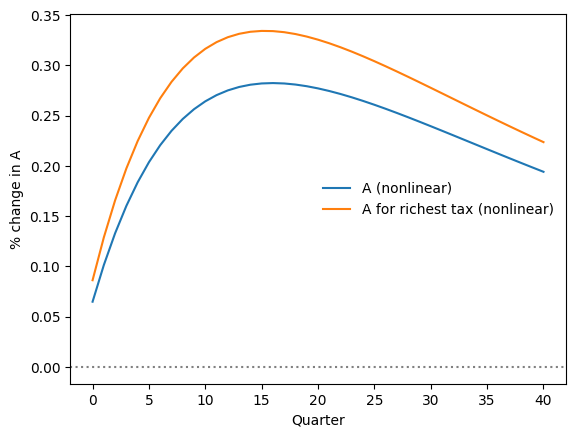

In [32]:
# Solve for the economy's response under NORMAL taxation (everyone pays future taxes)
# This simulates what happens quarter-by-quarter after the government increases debt
irf = models['ha'].solve_impulse_nonlinear(
    ss['ha'],                           # ss['ha'] = the steady state (normal equilibrium) of the heterogeneous agent model
    unknowns=['Y'],                     # Y (output/GDP) is what the model will solve for endogenously - it finds the value of Y that makes the economy balance
    targets=['asset_mkt'],              # Ensure the asset market clears (total assets supplied = total assets demanded by households)
    inputs={'B': dB*0.01},             # The shock: increase government debt (B) by 1% (dB*0.01 means "debt change times 0.01")
    outputs=['Y', 'A', 'C', 'wN_aftertax', 'N'],  # Track these variables: Y=output, A=aggregate assets, C=consumption, wN_aftertax=after-tax income, N=labor
    Js=Js,                              # Js = pre-computed Jacobian matrices that describe how the economy responds to shocks (derivatives of all equations)
)

# Solve for the economy's response under RICHEST-ONLY taxation (only rich pay future taxes)
# This uses a modified model where the tax burden falls only on wealthy households
irf_richest = model_ha_richest.solve_impulse_nonlinear(
    ss['ha'],                           # Start from the same steady state as before (for fair comparison)
    unknowns=['Y'],                     # Again, solve for output endogenously
    targets=['asset_mkt'],              # Again, ensure asset market clears
    inputs={'B': dB*0.01},             # Same 1% debt increase shock as in the first simulation
    outputs=['Y', 'A', 'C', 'wN_aftertax', 'N'],  # Track the same variables for comparison
    Js=Js,                              # Use the same Jacobian matrices
)

# Set how many time periods (quarters) to show in the graph
T_plot = 41  # 41 quarters = about 10 years of data

# Extract the path of aggregate assets (A) from the normal taxation simulation
# This is an array showing A in quarter 0, quarter 1, quarter 2, etc.
A_path = irf['A']

# Extract the path of aggregate assets (A) from the richest-only taxation simulation
A_path_richest = irf_richest['A']

# Plot the first line: normal taxation scenario
# 100 * A_path[:T_plot] / ss['ha']['A'] converts to percentage change:
#   - A_path[:T_plot] = take first 41 quarters of asset data
#   - / ss['ha']['A'] = divide by steady-state assets (to get proportional change)
#   - * 100 = multiply by 100 to convert to percentage
plt.plot(100 * A_path[:T_plot] / ss['ha']['A'], label='A (nonlinear)')

# Plot the second line: richest-only taxation scenario
# Same calculation as above, but using data from the richest-tax simulation
plt.plot(100 * A_path_richest[:T_plot] / ss['ha']['A'], label='A for richest tax (nonlinear)')

# Add a horizontal reference line at y=0 (shows the steady state / no change level)
plt.axhline(0, color='gray', linestyle=':')  # Gray dotted line at zero

# Label the x-axis (horizontal axis) as "Quarter" (time periods)
plt.xlabel('Quarter')

# Label the y-axis (vertical axis) to show it's measuring percentage change in aggregate assets
plt.ylabel('% change in A')

# Add a legend (key) to identify which line is which, without a frame box around it
plt.legend(frameon=False)

plt.savefig('output/change_in_A.pdf', bbox_inches='tight')
plt.show()

## PART 6: PLOTTING

In [33]:
plt.rcParams.update({'font.size': 10, 'font.family': 'serif', 'figure.figsize': (4, 3)})

### Figure 2(a)

Saved: figure2a_deficit_by_model.pdf


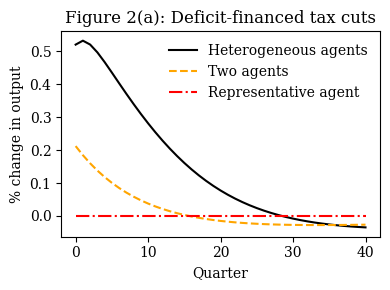

In [34]:
plt.figure()
plt.plot(irfs_B['ha'][:41], label='Heterogeneous agents', color='black')
plt.plot(irfs_B['ta'][:41], label='Two agents', linestyle='dashed', color='orange')
plt.plot(irfs_B['ra'][:41], label='Representative agent', linestyle='dashdot', color='red')
plt.legend(frameon=False)
plt.xlabel('Quarter')
plt.ylabel('% change in output')
plt.title('Figure 2(a): Deficit-financed tax cuts')
plt.tight_layout()
plt.savefig('output/figure2a_deficit_by_model.pdf', bbox_inches='tight')
print("Saved: figure2a_deficit_by_model.pdf")

### Figure 2(b)

Saved: figure2b_deficit_alternative_rules.pdf


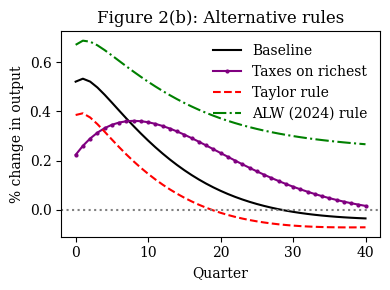

In [35]:
plt.figure()
plt.plot(irfs_B['ha'][:41], label='Baseline', color='black')
plt.plot(irf_B_richest[:41], label='Taxes on richest', linestyle='-', color='#800080', marker='o', markersize=2)
plt.plot(irf_B_taylor[:41], label='Taylor rule', linestyle='dashed', color='red')
plt.plot(irf_B_ALW[:41], label='ALW (2024) rule', linestyle='dashdot', color='green')
plt.axhline(y=0, linestyle='dotted', color='gray')
plt.legend(frameon=False)
plt.xlabel('Quarter')
plt.ylabel('% change in output')
plt.title('Figure 2(b): Alternative rules')
plt.tight_layout()
plt.savefig('output/figure2b_deficit_alternative_rules.pdf', bbox_inches='tight')
print("Saved: figure2b_deficit_alternative_rules.pdf")

### IRF displaying the evolution of inequalities

Saved: inequality_evolution.pdf


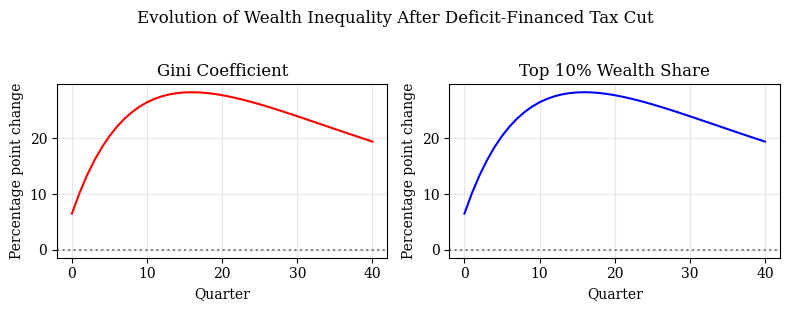

In [36]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 3))

# Gini coefficient evolution
ax1.plot(gini_irf, color='red', linewidth=1.5)
ax1.axhline(y=0, linestyle='dotted', color='gray')
ax1.set_xlabel('Quarter')
ax1.set_ylabel('Percentage point change')
ax1.set_title('Gini Coefficient')
ax1.grid(True, alpha=0.3)

# Top 10% wealth share evolution
ax2.plot(top10_irf, color='blue', linewidth=1.5)
ax2.axhline(y=0, linestyle='dotted', color='gray')
ax2.set_xlabel('Quarter')
ax2.set_ylabel('Percentage point change')
ax2.set_title('Top 10% Wealth Share')
ax2.grid(True, alpha=0.3)

plt.suptitle('Evolution of Wealth Inequality After Deficit-Financed Tax Cut', y=1.02)
plt.tight_layout()
plt.savefig('output/inequality_evolution.pdf', bbox_inches='tight')
print("Saved: inequality_evolution.pdf")
plt.show()

## PART 7: INEQUALITY IRFs WITH THE TWO-AGENT MODEL

This code computes the evolution of inequality measures after a deficit-financed tax cut using the Two-Agent (TA) model. The TA model has two household types:

1. Constrained (hand-to-mouth): consume all income, hold no assets
2. Unconstrained: smooth consumption, hold all assets

In [37]:
print("\n" + "="*80)
print("COMPUTING INEQUALITY EVOLUTION WITH TWO-AGENT MODEL")
print("="*80)


COMPUTING INEQUALITY EVOLUTION WITH TWO-AGENT MODEL


### Extract steady-state values from the two-agent model

In [38]:
# Get the share of hand-to-mouth households
lam = ss['ta']['lam']  # Share of constrained households
share_unconstrained = 1 - lam  # Share of unconstrained households

# Get steady-state consumption levels
C_RA_ss = ss['ta']['C_RA']  # Consumption of unconstrained households
C_H2M_ss = ss['ta']['wN_aftertax']  # Consumption of hand-to-mouth = their income
C_total_ss = ss['ta']['C']  # Total aggregate consumption
A_ss = ss['ta']['A']  # Total assets (held only by unconstrained)

print(f"\nSteady State (Two-Agent Model):")
print(f"  Share of constrained HH: {lam:.1%}")
print(f"  Share of unconstrained HH: {share_unconstrained:.1%}")
print(f"  Consumption (constrained): {C_H2M_ss:.4f}")
print(f"  Consumption (unconstrained): {C_RA_ss:.4f}")
print(f"  Total consumption: {C_total_ss:.4f}")
print(f"  Total assets: {A_ss:.4f}")


Steady State (Two-Agent Model):
  Share of constrained HH: 19.5%
  Share of unconstrained HH: 80.5%
  Consumption (constrained): 0.7000
  Consumption (unconstrained): 0.8242
  Total consumption: 0.8000
  Total assets: 20.0000


### Solve for IRFs with Aggregate Variables

In [39]:
print("\nSolving for IRFs...")

# Solve for the impulse response of key aggregate variables
irf_ta_detailed = models['ta'].solve_impulse_linear(
    ss['ta'],                      # Two-agent steady state
    unknowns=['Y'],                # Output adjusts endogenously
    targets=['asset_mkt'],         # Asset market clears
    inputs={'B': dB},              # Same deficit-financed tax cut shock
    outputs=['A', 'C', 'wN_aftertax', 'r', 'Y', 'N']  # Track key aggregates
)

# Extract paths
A_irf_ta = irf_ta_detailed['A']  # Total assets over time
C_irf_ta = irf_ta_detailed['C']  # Total consumption over time
wN_aftertax_irf_ta = irf_ta_detailed['wN_aftertax']  # After-tax income over time
Y_irf_ta = irf_ta_detailed['Y']  # Output over time
r_irf_ta = irf_ta_detailed['r']  # Real interest rate over time


Solving for IRFs...


### Recover Household-Level Consumption from Aggregates

In the two-agent model:

C_H2M = wN_aftertax  (hand-to-mouth consume all their income)

C = (1 - lam) * C_RA + lam * C_H2M

We can solve for C_RA:

C_RA = (C - lam * C_H2M) / (1 - lam)

C_RA = (C - lam * wN_aftertax) / (1 - lam)

In [40]:
# Compute consumption of hand-to-mouth households (they consume all after-tax income)
C_H2M_irf = wN_aftertax_irf_ta.copy()

# Compute consumption of unconstrained households by backing out from aggregate
# Total consumption: C = (1-lam)*C_RA + lam*C_H2M
# Solving for C_RA: C_RA = (C - lam*C_H2M) / (1-lam)
C_RA_irf = (C_irf_ta - lam * C_H2M_irf) / (1 - lam)

# Verify the accounting identity holds
C_total_check = (1 - lam) * C_RA_irf + lam * C_H2M_irf
max_error = np.max(np.abs(C_irf_ta - C_total_check))
assert max_error < 1e-10, f"Consumption accounting error: {max_error}"

print("IRFs computed successfully!")
print(f"  Periods computed: {len(A_irf_ta)}")
print(f"  Consumption accounting verified (max error: {max_error:.2e})")

IRFs computed successfully!
  Periods computed: 400
  Consumption accounting verified (max error: 0.00e+00)


### Define Inequality Metrics Function for TA Model

This computes inequality measures for the Two-Agent New Keynesian (TANK) model.

In this model:

- Constrained households hold ZERO assets
- Unconstrained households hold ALL assets
- This makes inequality measures very straightforward

Parameters:

- c_constrained : Consumption of hand-to-mouth (constrained) households
- c_unconstrained : Consumption of unconstrained (patient) households
- A : Total assets in the economy (all held by unconstrained)
- share_constrained : Population share of constrained households
- share_unconstrained : Population share of unconstrained households

Returns: dict with inequality measures

In [41]:
def compute_tank_inequality(c_constrained, c_unconstrained, A,
                            share_constrained, share_unconstrained):
    # WEALTH INEQUALITY
    # In the TA model, wealth inequality is maximal and simple:
    # - Constrained households: 0 wealth
    # - Unconstrained households: ALL wealth

    # Wealth Gini coefficient for two groups (one with 0, one with all)
    # Formula: Gini = (share who have nothing)
    wealth_gini = share_constrained

    # Top wealth share: unconstrained hold 100% of wealth
    top_wealth_share = 1.0

    # Wealth per capita
    wealth_per_capita_constrained = 0.0
    wealth_per_capita_unconstrained = A / share_unconstrained

    # CONSUMPTION INEQUALITY
    # Total consumption
    total_c = share_constrained * c_constrained + share_unconstrained * c_unconstrained

    # Consumption shares (as fraction of total consumption)
    c_share_constrained = share_constrained * c_constrained / total_c
    c_share_unconstrained = share_unconstrained * c_unconstrained / total_c

    # Consumption Gini (simplified for two groups)
    # The Gini for two groups is related to the absolute deviation from equal shares
    c_gini = np.abs(c_share_constrained - share_constrained) + \
             np.abs(c_share_unconstrained - share_unconstrained)
    c_gini = c_gini / 2  # Normalize

    # Consumption ratio (unconstrained vs constrained)
    c_ratio = c_unconstrained / c_constrained

    # Consumption per capita
    c_per_capita_constrained = c_constrained
    c_per_capita_unconstrained = c_unconstrained

    return {
        'wealth_gini': wealth_gini,
        'top_wealth_share': top_wealth_share,
        'wealth_per_capita_constrained': wealth_per_capita_constrained,
        'wealth_per_capita_unconstrained': wealth_per_capita_unconstrained,
        'consumption_gini': c_gini,
        'consumption_ratio': c_ratio,
        'consumption_share_constrained': c_share_constrained,
        'consumption_share_unconstrained': c_share_unconstrained,
        'c_per_capita_constrained': c_per_capita_constrained,
        'c_per_capita_unconstrained': c_per_capita_unconstrained
    }

### Compute Steady-State Inequality

In [42]:
print("\n" + "-"*80)
print("STEADY STATE INEQUALITY MEASURES")
print("-"*80)

ineq_ss_ta = compute_tank_inequality(
    C_H2M_ss,
    C_RA_ss,
    A_ss,
    lam,
    share_unconstrained
)

print(f"Wealth Gini:                     {ineq_ss_ta['wealth_gini']:.4f}")
print(f"Top wealth share:                {ineq_ss_ta['top_wealth_share']*100:.1f}%")
print(f"Consumption Gini:                {ineq_ss_ta['consumption_gini']:.4f}")
print(f"Consumption ratio (U/C):         {ineq_ss_ta['consumption_ratio']:.4f}")
print(f"Wealth per capita (constrained): ${ineq_ss_ta['wealth_per_capita_constrained']:.2f}")
print(f"Wealth per capita (unconstr.):   ${ineq_ss_ta['wealth_per_capita_unconstrained']:.2f}")
print(f"Cons. share (constrained):       {ineq_ss_ta['consumption_share_constrained']*100:.2f}%")
print(f"Cons. share (unconstrained):     {ineq_ss_ta['consumption_share_unconstrained']*100:.2f}%")


--------------------------------------------------------------------------------
STEADY STATE INEQUALITY MEASURES
--------------------------------------------------------------------------------
Wealth Gini:                     0.1950
Top wealth share:                100.0%
Consumption Gini:                0.0244
Consumption ratio (U/C):         1.1775
Wealth per capita (constrained): $0.00
Wealth per capita (unconstr.):   $24.85
Cons. share (constrained):       17.06%
Cons. share (unconstrained):     82.94%


### Compute Inequality IRF Along the Path

In [44]:
print("\n" + "-"*80)
print("COMPUTING INEQUALITY EVOLUTION OVER IRF PATH")
print("-"*80)

# Number of periods to analyze
T_plot = 40  # First 40 quarters (10 years)

# Initialize arrays to store inequality measures
wealth_gini_irf_ta = np.zeros(T_plot)
consumption_gini_irf_ta = np.zeros(T_plot)
consumption_ratio_irf_ta = np.zeros(T_plot)
wealth_pc_unc_irf_ta = np.zeros(T_plot)
c_share_const_irf_ta = np.zeros(T_plot)
c_share_uncon_irf_ta = np.zeros(T_plot)

# Compute inequality at each point along the IRF
for t in range(T_plot):
    # At each time t, we have the LEVELS (not deviations) of variables
    # since the IRF gives us the path including the steady state

    # Get levels at time t
    c_constrained_t = C_H2M_ss + C_H2M_irf[t]  # Level of constrained consumption
    c_unconstrained_t = C_RA_ss + C_RA_irf[t]   # Level of unconstrained consumption
    A_t = A_ss + A_irf_ta[t]                     # Level of assets

    # Compute inequality measures at time t
    ineq_t = compute_tank_inequality(
        c_constrained_t,
        c_unconstrained_t,
        A_t,
        lam,
        share_unconstrained
    )

    # Store the measures
    wealth_gini_irf_ta[t] = ineq_t['wealth_gini']
    consumption_gini_irf_ta[t] = ineq_t['consumption_gini']
    consumption_ratio_irf_ta[t] = ineq_t['consumption_ratio']
    wealth_pc_unc_irf_ta[t] = ineq_t['wealth_per_capita_unconstrained']
    c_share_const_irf_ta[t] = ineq_t['consumption_share_constrained']
    c_share_uncon_irf_ta[t] = ineq_t['consumption_share_unconstrained']

# Convert to deviations from steady state for easier interpretation
wealth_gini_dev_ta = (wealth_gini_irf_ta - ineq_ss_ta['wealth_gini']) * 100  # pp
consumption_gini_dev_ta = (consumption_gini_irf_ta - ineq_ss_ta['consumption_gini']) * 100  # pp
consumption_ratio_dev_ta = (consumption_ratio_irf_ta - ineq_ss_ta['consumption_ratio']) / ineq_ss_ta['consumption_ratio'] * 100  # %
wealth_pc_unc_dev_ta = (wealth_pc_unc_irf_ta - ineq_ss_ta['wealth_per_capita_unconstrained']) / ineq_ss_ta['wealth_per_capita_unconstrained'] * 100  # %
c_share_const_dev_ta = (c_share_const_irf_ta - ineq_ss_ta['consumption_share_constrained']) * 100  # pp
c_share_uncon_dev_ta = (c_share_uncon_irf_ta - ineq_ss_ta['consumption_share_unconstrained']) * 100  # pp

print("Inequality IRFs computed!")


--------------------------------------------------------------------------------
COMPUTING INEQUALITY EVOLUTION OVER IRF PATH
--------------------------------------------------------------------------------
Inequality IRFs computed!


### Print Findings

In [45]:
print("\n" + "="*80)
print("KEY FINDINGS: INEQUALITY DYNAMICS (TWO-AGENT MODEL)")
print("="*80)

# Initial impact (t=0)
print("\n1. IMMEDIATE IMPACT (Quarter 0):")
print(f"   Consumption Gini:        {consumption_gini_dev_ta[0]:+.4f} pp")
print(f"   Consumption Ratio (U/C): {consumption_ratio_dev_ta[0]:+.3f}%")
print(f"   Wealth per cap. (uncon): {wealth_pc_unc_dev_ta[0]:+.3f}%")
print(f"   Cons. share (constr.):   {c_share_const_dev_ta[0]:+.3f} pp")

# Peak responses
peak_c_gini_idx = np.argmax(np.abs(consumption_gini_dev_ta))
peak_c_ratio_idx = np.argmax(np.abs(consumption_ratio_dev_ta))
peak_wealth_idx = np.argmax(np.abs(wealth_pc_unc_dev_ta))

print("\n2. PEAK RESPONSES:")
print(f"   Consumption Gini:        {consumption_gini_dev_ta[peak_c_gini_idx]:+.4f} pp at quarter {peak_c_gini_idx}")
print(f"   Consumption Ratio:       {consumption_ratio_dev_ta[peak_c_ratio_idx]:+.3f}% at quarter {peak_c_ratio_idx}")
print(f"   Wealth per cap. (uncon): {wealth_pc_unc_dev_ta[peak_wealth_idx]:+.3f}% at quarter {peak_wealth_idx}")

# Longer-run (quarter 20, ~5 years out)
print("\n3. MEDIUM-RUN (Quarter 20, ~5 years):")
print(f"   Consumption Gini:        {consumption_gini_dev_ta[20]:+.4f} pp")
print(f"   Consumption Ratio (U/C): {consumption_ratio_dev_ta[20]:+.3f}%")
print(f"   Wealth per cap. (uncon): {wealth_pc_unc_dev_ta[20]:+.3f}%")
print(f"   Cons. share (constr.):   {c_share_const_dev_ta[20]:+.3f} pp")

# Consumption response by type
print("\n4. CONSUMPTION RESPONSES BY TYPE:")
print(f"   Constrained (peak):      {np.max(C_H2M_irf[:T_plot]/C_H2M_ss*100):+.3f}% at quarter {np.argmax(C_H2M_irf[:T_plot])}")
print(f"   Unconstrained (peak):    {np.max(C_RA_irf[:T_plot]/C_RA_ss*100):+.3f}% at quarter {np.argmax(C_RA_irf[:T_plot])}")

# Interpretation
print("\n5. ECONOMIC INTERPRETATION:")
if consumption_ratio_dev_ta[5] > 0:
    print("   Inequality INCREASES in the short run")
    print("   Unconstrained households benefit more from the stimulus")
    print("   Evidence of 'trickling up': assets flow to patient savers")
else:
    print("   Inequality DECREASES in the short run")
    print("   Constrained households receive larger immediate income boost")

if wealth_pc_unc_dev_ta[39] > wealth_pc_unc_dev_ta[0]:
    print("   Long-run: Wealth concentration among unconstrained persists")
else:
    print("   Long-run: Wealth effects diminish")

print("\n" + "="*80)


KEY FINDINGS: INEQUALITY DYNAMICS (TWO-AGENT MODEL)

1. IMMEDIATE IMPACT (Quarter 0):
   Consumption Gini:        +12.5082 pp
   Consumption Ratio (U/C): -60.846%
   Wealth per cap. (uncon): +4.378%
   Cons. share (constr.):   +17.384 pp

2. PEAK RESPONSES:
   Consumption Gini:        +12.5082 pp at quarter 0
   Consumption Ratio:       -60.846% at quarter 0
   Wealth per cap. (uncon): +28.249% at quarter 17

3. MEDIUM-RUN (Quarter 20, ~5 years):
   Consumption Gini:        +1.5885 pp
   Consumption Ratio (U/C): +12.376%
   Wealth per cap. (uncon): +27.917%
   Cons. share (constr.):   -1.589 pp

4. CONSUMPTION RESPONSES BY TYPE:
   Constrained (peak):      +155.404% at quarter 0
   Unconstrained (peak):    +0.000% at quarter 0

5. ECONOMIC INTERPRETATION:
   Inequality DECREASES in the short run
   Constrained households receive larger immediate income boost
   Long-run: Wealth concentration among unconstrained persists



### Create Visualizations

#### Multiple Subplot Figure


Generating plots...
 Saved: output/inequality_evolution_two_agent.pdf


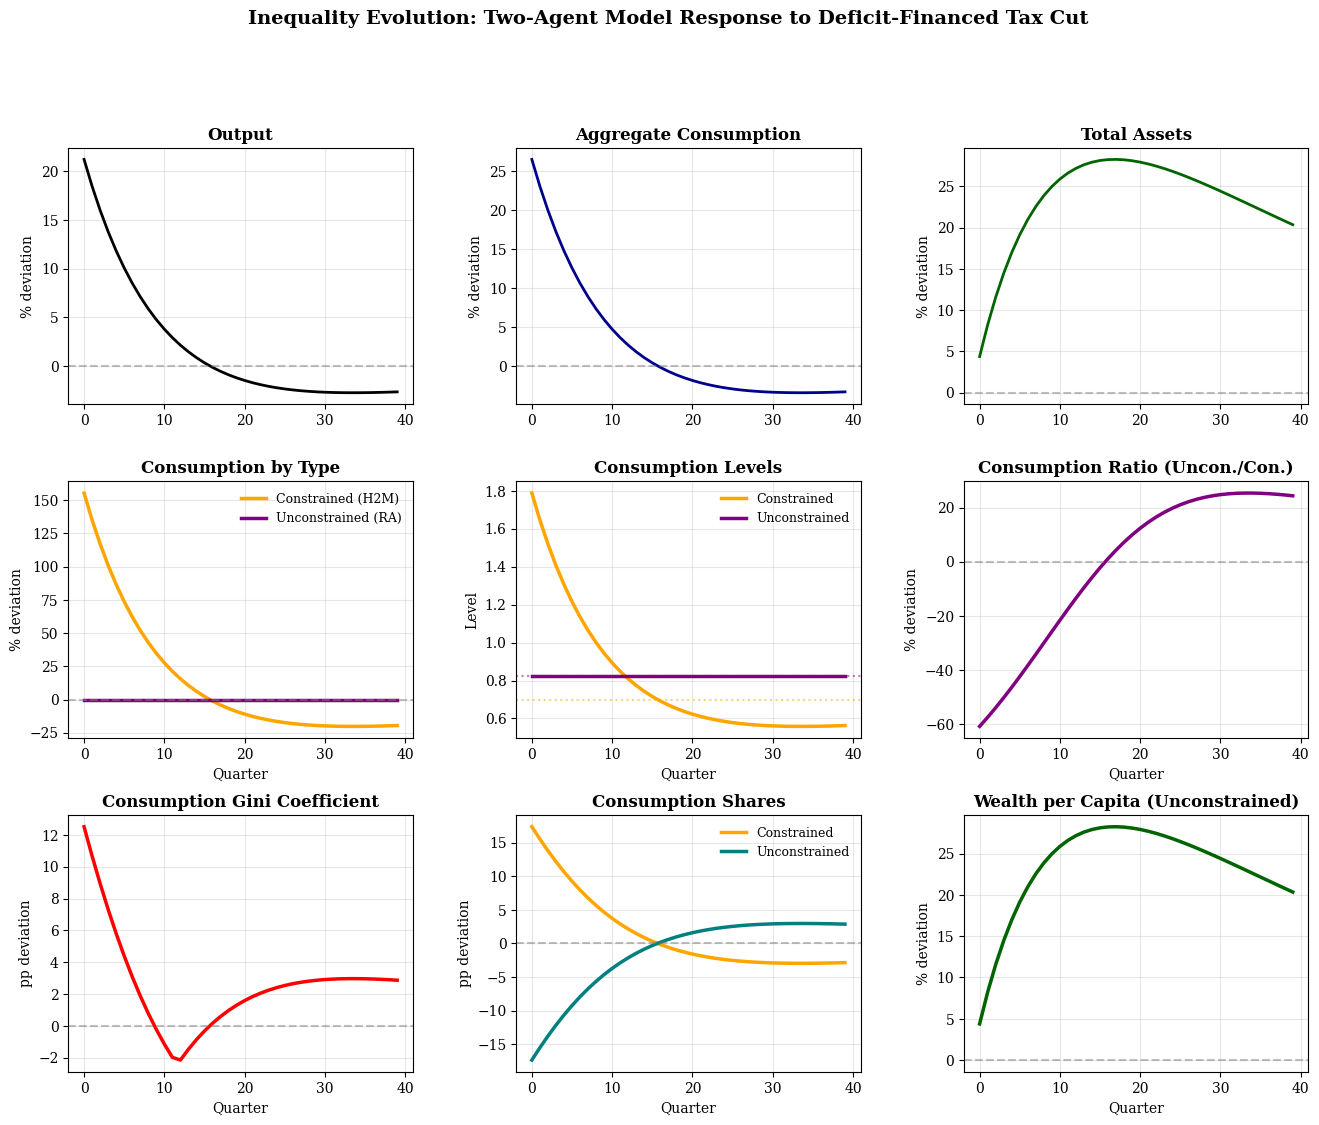

In [46]:
print("\nGenerating plots...")

# Create figure with multiple subplots
fig = plt.figure(figsize=(16, 12))
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

# Row 1: Macroeconomic aggregates
ax1 = fig.add_subplot(gs[0, 0])
ax1.plot(Y_irf_ta[:T_plot] / ss['ta']['Y'] * 100, color='black', linewidth=2)
ax1.axhline(0, color='gray', linestyle='--', alpha=0.5)
ax1.set_title('Output', fontsize=12, fontweight='bold')
ax1.set_ylabel('% deviation', fontsize=10)
ax1.grid(alpha=0.3)

ax2 = fig.add_subplot(gs[0, 1])
ax2.plot(C_irf_ta[:T_plot] / ss['ta']['C'] * 100, color='darkblue', linewidth=2)
ax2.axhline(0, color='gray', linestyle='--', alpha=0.5)
ax2.set_title('Aggregate Consumption', fontsize=12, fontweight='bold')
ax2.set_ylabel('% deviation', fontsize=10)
ax2.grid(alpha=0.3)

ax3 = fig.add_subplot(gs[0, 2])
ax3.plot(A_irf_ta[:T_plot] / ss['ta']['A'] * 100, color='darkgreen', linewidth=2)
ax3.axhline(0, color='gray', linestyle='--', alpha=0.5)
ax3.set_title('Total Assets', fontsize=12, fontweight='bold')
ax3.set_ylabel('% deviation', fontsize=10)
ax3.grid(alpha=0.3)

# Row 2: Consumption by type
ax4 = fig.add_subplot(gs[1, 0])
ax4.plot(C_H2M_irf[:T_plot] / C_H2M_ss * 100,
         label='Constrained (H2M)', color='orange', linewidth=2.5)
ax4.plot(C_RA_irf[:T_plot] / C_RA_ss * 100,
         label='Unconstrained (RA)', color='purple', linewidth=2.5)
ax4.axhline(0, color='gray', linestyle='--', alpha=0.5)
ax4.set_title('Consumption by Type', fontsize=12, fontweight='bold')
ax4.set_ylabel('% deviation', fontsize=10)
ax4.set_xlabel('Quarter', fontsize=10)
ax4.legend(frameon=False, fontsize=9)
ax4.grid(alpha=0.3)

ax5 = fig.add_subplot(gs[1, 1])
# Plot consumption levels
quarters = np.arange(T_plot)
c_const_level = C_H2M_ss + C_H2M_irf[:T_plot]
c_uncon_level = C_RA_ss + C_RA_irf[:T_plot]
ax5.plot(quarters, c_const_level, label='Constrained', color='orange', linewidth=2.5)
ax5.plot(quarters, c_uncon_level, label='Unconstrained', color='purple', linewidth=2.5)
ax5.axhline(C_H2M_ss, color='orange', linestyle=':', alpha=0.5)
ax5.axhline(C_RA_ss, color='purple', linestyle=':', alpha=0.5)
ax5.set_title('Consumption Levels', fontsize=12, fontweight='bold')
ax5.set_ylabel('Level', fontsize=10)
ax5.set_xlabel('Quarter', fontsize=10)
ax5.legend(frameon=False, fontsize=9)
ax5.grid(alpha=0.3)

ax6 = fig.add_subplot(gs[1, 2])
ax6.plot(consumption_ratio_dev_ta, color='purple', linewidth=2.5)
ax6.axhline(0, color='gray', linestyle='--', alpha=0.5)
ax6.set_title('Consumption Ratio (Uncon./Con.)', fontsize=12, fontweight='bold')
ax6.set_ylabel('% deviation', fontsize=10)
ax6.set_xlabel('Quarter', fontsize=10)
ax6.grid(alpha=0.3)

# Row 3: Inequality measures
ax7 = fig.add_subplot(gs[2, 0])
ax7.plot(consumption_gini_dev_ta, color='red', linewidth=2.5)
ax7.axhline(0, color='gray', linestyle='--', alpha=0.5)
ax7.set_title('Consumption Gini Coefficient', fontsize=12, fontweight='bold')
ax7.set_ylabel('pp deviation', fontsize=10)
ax7.set_xlabel('Quarter', fontsize=10)
ax7.grid(alpha=0.3)

ax8 = fig.add_subplot(gs[2, 1])
ax8.plot(c_share_const_dev_ta, label='Constrained', color='orange', linewidth=2.5)
ax8.plot(c_share_uncon_dev_ta, label='Unconstrained', color='teal', linewidth=2.5)
ax8.axhline(0, color='gray', linestyle='--', alpha=0.5)
ax8.set_title('Consumption Shares', fontsize=12, fontweight='bold')
ax8.set_ylabel('pp deviation', fontsize=10)
ax8.set_xlabel('Quarter', fontsize=10)
ax8.legend(frameon=False, fontsize=9)
ax8.grid(alpha=0.3)

ax9 = fig.add_subplot(gs[2, 2])
ax9.plot(wealth_pc_unc_dev_ta, color='darkgreen', linewidth=2.5)
ax9.axhline(0, color='gray', linestyle='--', alpha=0.5)
ax9.set_title('Wealth per Capita (Unconstrained)', fontsize=12, fontweight='bold')
ax9.set_ylabel('% deviation', fontsize=10)
ax9.set_xlabel('Quarter', fontsize=10)
ax9.grid(alpha=0.3)

plt.suptitle('Inequality Evolution: Two-Agent Model Response to Deficit-Financed Tax Cut',
             fontsize=14, fontweight='bold', y=0.995)

plt.savefig('output/inequality_evolution_two_agent.pdf', bbox_inches='tight', dpi=300)
print(" Saved: output/inequality_evolution_two_agent.pdf")
plt.show()

#### Focused Inequality Plot

 Saved: output/inequality_evolution_two_agent_focused.pdf


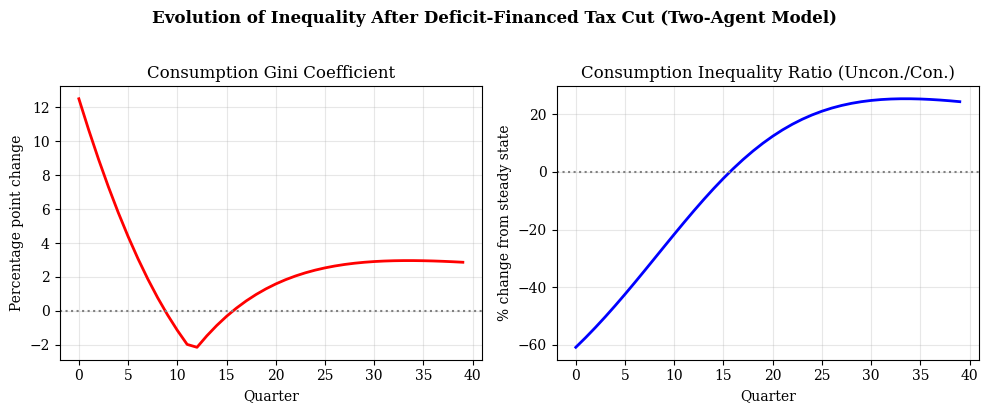

In [47]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

# Consumption Gini evolution
ax1.plot(consumption_gini_dev_ta, color='red', linewidth=2)
ax1.axhline(y=0, linestyle='dotted', color='gray')
ax1.set_xlabel('Quarter')
ax1.set_ylabel('Percentage point change')
ax1.set_title('Consumption Gini Coefficient')
ax1.grid(True, alpha=0.3)

# Consumption ratio evolution (as proxy for inequality)
ax2.plot(consumption_ratio_dev_ta, color='blue', linewidth=2)
ax2.axhline(y=0, linestyle='dotted', color='gray')
ax2.set_xlabel('Quarter')
ax2.set_ylabel('% change from steady state')
ax2.set_title('Consumption Inequality Ratio (Uncon./Con.)')
ax2.grid(True, alpha=0.3)

plt.suptitle('Evolution of Inequality After Deficit-Financed Tax Cut (Two-Agent Model)',
             y=1.02, fontsize=12, fontweight='bold')
plt.tight_layout()
plt.savefig('output/inequality_evolution_two_agent_focused.pdf', bbox_inches='tight', dpi=300)
print(" Saved: output/inequality_evolution_two_agent_focused.pdf")
plt.show()

The Two-Agent model provides a way to track inequality dynamics:

- Constrained (hand-to-mouth) households: consume all income, hold no wealth
- Unconstrained (patient) households: smooth consumption, hold all wealth

This structure makes inequality measures straightforward to compute, unlike the full HA model where accessing the distribution D_t is difficult.

The fiscal shock affects the two groups differently, creating distributional dynamics that can be precisely tracked over time.